In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
import sqlite3
from pprint import pprint
from sklearn.metrics import f1_score

# im being really lazy here, just want to get something working
%env OPENAI_API_KEY=this-doesnt-matter

from sqlite_helper import sqlitefile_to_dataframe


env: OPENAI_API_KEY=this-doesnt-matter


# Baseline Experiments Results Visualization

In [53]:
# easy data in here
easy_dir = './checkpoints/with-compile-commands-and-template-handling-inst'

# hard data in here
hard_dir = './checkpoints/'

dirs_list = [easy_dir, hard_dir]

# get all the sqlite files in the db_dir
sqlite_files = [os.path.join(d,f) for d in dirs_list for f in os.listdir(d) if f.endswith('.sqlite')]

for sqlite_file in sqlite_files:
    print(f"Processing [{sqlite_file}]") 


# keep only the ones with gpt-5-mini in the name
sqlite_files = [f for f in sqlite_files if 'gpt-5-mini' in f]

print(sqlite_files)

Processing [./checkpoints/with-compile-commands-and-template-handling-inst/openai-gpt-5-mini:fullPrompt:openrouter.sqlite]
Processing [./checkpoints/with-compile-commands-and-template-handling-inst/openai-gpt-5-mini:simplePrompt:openrouter.sqlite]
Processing [./checkpoints/gpt-5-mini:fullPrompt:azure:hardDataset.sqlite]
Processing [./checkpoints/gpt-5-mini:simplePrompt:azure:hardDataset.sqlite]
['./checkpoints/with-compile-commands-and-template-handling-inst/openai-gpt-5-mini:fullPrompt:openrouter.sqlite', './checkpoints/with-compile-commands-and-template-handling-inst/openai-gpt-5-mini:simplePrompt:openrouter.sqlite', './checkpoints/gpt-5-mini:fullPrompt:azure:hardDataset.sqlite', './checkpoints/gpt-5-mini:simplePrompt:azure:hardDataset.sqlite']


In [54]:
df = pd.DataFrame()

for sqlite_file in sqlite_files:
    filedf = sqlitefile_to_dataframe(sqlite_file)

    print(f'File DF Size: {filedf.shape} for file {sqlite_file}')

    df = pd.concat([df, filedf], ignore_index=True)



File DF Size: (609, 36) for file ./checkpoints/with-compile-commands-and-template-handling-inst/openai-gpt-5-mini:fullPrompt:openrouter.sqlite
File DF Size: (609, 36) for file ./checkpoints/with-compile-commands-and-template-handling-inst/openai-gpt-5-mini:simplePrompt:openrouter.sqlite
File DF Size: (1065, 36) for file ./checkpoints/gpt-5-mini:fullPrompt:azure:hardDataset.sqlite
File DF Size: (1072, 36) for file ./checkpoints/gpt-5-mini:simplePrompt:azure:hardDataset.sqlite


In [55]:
renamed_categories = {
    'Zero SP + DP FLOP': 'No FLOPs',
    'Non-zero SP FLOP': 'SP-Only',
    'Non-zero DP FLOP': 'DP-Only',
    'Non-zero SP + DP FLOP': 'Mixed'
}

df['nnz_flop_state'] = df['nnz_flop_state'].map(renamed_categories)
df['predicted_nnz_flop_state'] = df['predicted_nnz_flop_state'].map(renamed_categories)

In [56]:
print(df.columns)

print(df.head(10))
print(f'DF Size: {df.shape}')

# print the df datatypes
# print(df.dtypes)

print(df.error.value_counts( dropna=False ))

Index(['combined_name', 'model_name', 'provider', 'trial_number',
       'prompt_type', 'variant_type', 'nnz_flop_state', 'top_p', 'temp',
       'langgraph_thread_id', 'source_code', 'kernel_name', 'exec_args',
       'grid_size', 'block_size', 'total_num_threads', 'compile_commands',
       'empirical_sp_flop_count', 'empirical_dp_flop_count', 'raw_flop_counts',
       'predicted_sp_flop_count', 'predicted_dp_flop_count',
       'predicted_sp_flop_count_explanation',
       'predicted_dp_flop_count_explanation', 'input_tokens', 'output_tokens',
       'total_cost', 'total_query_time', 'error', 'state_of_failure',
       'generic_model_name', 'has_nz_flops', 'difficulty',
       'predicted_nnz_flop_state', 'percent_diff_sp', 'percent_diff_dp'],
      dtype='object')
                       combined_name         model_name  \
0  (ace-cuda, boundaryConditionsPhi)  openai/gpt-5-mini   
1  (ace-cuda, boundaryConditionsPhi)  openai/gpt-5-mini   
2  (ace-cuda, boundaryConditionsPhi)  openai/

## Helper functions for plotting 

In [57]:
# now we want to plot the prediction accuracy vs. the ground truth for each generic_model_name and prompt_type
def make_sp_dp_nnz_cdf_plot(nnz_sp_data, nnz_dp_data, title):
    # let's make a cdf plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)

    sns.ecdfplot(nnz_sp_data, label='SP FLOP', ax=ax, color='orange')
    sns.ecdfplot(nnz_dp_data, label='DP FLOP', ax=ax, color='blue')

    ax.set_xscale('symlog')
    #ax.set_yscale('log')
    ax.set_xlabel('Percent Difference (%)')
    ax.set_ylabel('Proportion of Data <= X')
    ax.legend()
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


    ##############################################
    percents = [1, 5, 10, 50, 75, 99, 100]
    for perc in percents:
        num_sp_within_xpct = ((nnz_sp_data > -perc) & (nnz_sp_data < perc)).sum()
        num_sp_outside_xpct = ((nnz_sp_data <= -perc) | (nnz_sp_data >= perc)).sum()

        num_dp_within_xpct = ((nnz_dp_data > -perc) & (nnz_dp_data < perc)).sum()
        num_dp_outside_xpct = ((nnz_dp_data <= -perc) | (nnz_dp_data >= perc)).sum()

        total_sp = nnz_sp_data.shape[0]
        total_dp = nnz_dp_data.shape[0]

        print(f'SP FLOP: {num_sp_within_xpct} / {total_sp} ({100*num_sp_within_xpct/total_sp:.2f}%) within +/- {perc}%')
        print(f'SP FLOP: {num_sp_outside_xpct} / {total_sp} ({100*num_sp_outside_xpct/total_sp:.2f}%) outside +/- {perc}%')
        print(f'DP FLOP: {num_dp_within_xpct} / {total_dp} ({100*num_dp_within_xpct/total_dp:.2f}%) within +/- {perc}%')
        print(f'DP FLOP: {num_dp_outside_xpct} / {total_dp} ({100*num_dp_outside_xpct/total_dp:.2f}%) outside +/- {perc}%')
        print("\n")

    print("\n")

In [58]:

def plot_classification_confusion_matrix(success_df, truth_col='nnz_flop_state', pred_col='predicted_nnz_flop_state', normalize=False, title=None, figsize=(6,5), cmap='Blues'):
    """
    Plot a confusion matrix (heatmap) comparing two categorical columns in a dataframe.

    Additionally computes and prints per-class precision, recall and F1 scores,
    and prints the macro-average F1 score.

    Parameters:

    """
    # guard: make sure columns exist
    if truth_col not in success_df.columns or pred_col not in success_df.columns:
        raise ValueError(f'Columns {truth_col} and/or {pred_col} not found in dataframe')

    # extract labels from both columns to ensure symmetric matrix ordering
    truth_vals = success_df[truth_col].dropna().unique().tolist()
    pred_vals = success_df[pred_col].dropna().unique().tolist()
    #labels = sorted(list(set(truth_vals) | set(pred_vals)))
    # ensure labels is a concrete list (renamed_categories.values() may be a view)
    labels = list(renamed_categories.values())


    # compute counts using pandas crosstab and ensure rows/cols order
    cm = pd.crosstab(success_df[truth_col], success_df[pred_col], rownames=['Actual'], colnames=['Predicted'], dropna=False)
    cm = cm.reindex(index=labels, columns=labels, fill_value=0)

    # compute row-normalized percentages (for annotation). This is percent of actual (row) total)
    with np.errstate(all='ignore'):
        cm_percent = cm.div(cm.sum(axis=1).replace(0, np.nan), axis=0).fillna(0) * 100

    # Build annotation strings: count on first line, percentage on second line
    # e.g. '12\n(34.56%)'
    percent_str = cm_percent.round(2).astype(str)
    # make sure percentage strings have a percent sign and two decimals (handle 'nan' -> '0.00')
    percent_str = percent_str.replace('nan', '0.00')
    percent_str = percent_str.applymap(lambda x: f"{float(x):.2f}%")

    annot = cm.astype(int).astype(str) + '\n(' + percent_str + ')'

    # Compute per-class precision, recall, and F1 (macro-average at the end)
    f1_scores = {}
    precision_scores = {}
    recall_scores = {}
    for lbl in labels:
        # safe access in case label isn't present
        tp = int(cm.at[lbl, lbl]) if (lbl in cm.index and lbl in cm.columns) else 0
        predicted_total = int(cm[lbl].sum()) if (lbl in cm.columns) else 0
        actual_total = int(cm.loc[lbl].sum()) if (lbl in cm.index) else 0

        precision = tp / predicted_total if predicted_total > 0 else 0.0
        recall = tp / actual_total if actual_total > 0 else 0.0
        if precision + recall > 0:
            f1 = 2.0 * precision * recall / (precision + recall)
        else:
            f1 = 0.0

        precision_scores[lbl] = precision
        recall_scores[lbl] = recall
        f1_scores[lbl] = f1

    # Print a small table of precision/recall/F1 for each class
    print('\nPer-class classification metrics:')
    print(f"{'Class':<20} {'Prec':>7} {'Rec':>7} {'F1':>7} {'Support':>8}")
    for lbl in labels:
        support = int(cm.loc[lbl].sum()) if (lbl in cm.index) else 0
        print(f"{lbl:<20} {precision_scores[lbl]:7.4f} {recall_scores[lbl]:7.4f} {f1_scores[lbl]:7.4f} {support:8d}")

    # Macro-average F1
    macro_f1 = float(np.mean(list(f1_scores.values()))) if len(f1_scores) > 0 else 0.0
    print(f"\nMacro-average F1: {macro_f1:.4f}\n")

    # We still allow callers to request a normalized heatmap coloring via `normalize`,
    # but the displayed numbers should remain raw counts with percent annotations underneath.
    if normalize:
        # use normalized values for the colormap (0..100 -> scale to 0..1) but annotate with counts+percent,
        plot_df = cm_percent / 100.0
    else:
        plot_df = cm

    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=150)
    sns.heatmap(plot_df, annot=annot.values, fmt='', cmap=cmap, ax=ax, cbar=True, linewidths=0.5, linecolor='lightgray')

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    if title is None:
        t = f'Confusion Matrix: {truth_col} vs {pred_col}'
    else:
        t = title
    ax.set_title(t)

    # improve tick label appearance
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

    plt.tight_layout()
    plt.show()

    return cm

In [59]:
def plot_absolute_percent_prediction_error(success_df, title):
    nz_sp_data = success_df[success_df['empirical_sp_flop_count'] != 0].reset_index(drop=True)
    nz_dp_data = success_df[success_df['empirical_dp_flop_count'] != 0].reset_index(drop=True)

    z_sp_data = success_df[success_df['empirical_sp_flop_count'] == 0].reset_index(drop=True)
    z_dp_data = success_df[success_df['empirical_dp_flop_count'] == 0].reset_index(drop=True)

    nz_sp_data['abs_percent_diff_sp'] = nz_sp_data['percent_diff_sp'].abs()
    nz_dp_data['abs_percent_diff_dp'] = nz_dp_data['percent_diff_dp'].abs() 

    z_sp_data['abs_percent_diff_sp'] = z_sp_data['percent_diff_sp'].abs()
    z_dp_data['abs_percent_diff_dp'] = z_dp_data['percent_diff_dp'].abs()

    print(f'NZ SP Data Size: {nz_sp_data.shape}')
    print(f'NZ DP Data Size: {nz_dp_data.shape}')   

    mean_abs_percent_diff_sp = nz_sp_data['abs_percent_diff_sp'].mean()
    mean_abs_percent_diff_dp = nz_dp_data['abs_percent_diff_dp'].mean()
    median_abs_percent_diff_sp = nz_sp_data['abs_percent_diff_sp'].median()
    median_abs_percent_diff_dp = nz_dp_data['abs_percent_diff_dp'].median()

    mean_abs_percent_diff_sp_z = z_sp_data['abs_percent_diff_sp'].mean()
    mean_abs_percent_diff_dp_z = z_dp_data['abs_percent_diff_dp'].mean()
    median_abs_percent_diff_sp_z = z_sp_data['abs_percent_diff_sp'].median()
    median_abs_percent_diff_dp_z = z_dp_data['abs_percent_diff_dp'].median()

    # print the mean absolute percent difference for SP and DP  
    print(f'Mean Absolute Percent Difference SP: {mean_abs_percent_diff_sp:.2f}%')
    print(f'Mean Absolute Percent Difference DP: {mean_abs_percent_diff_dp:.2f}%')
    print(f'Median Absolute Percent Difference SP: {median_abs_percent_diff_sp:.2f}%')
    print(f'Median Absolute Percent Difference DP: {median_abs_percent_diff_dp:.2f}%')

    print(f'Mean Absolute Percent Difference SP (zero FLOP): {mean_abs_percent_diff_sp_z:.2f}%')
    print(f'Mean Absolute Percent Difference DP (zero FLOP): {mean_abs_percent_diff_dp_z:.2f}%')
    print(f'Median Absolute Percent Difference SP (zero FLOP): {median_abs_percent_diff_sp_z:.2f}%')
    print(f'Median Absolute Percent Difference DP (zero FLOP): {median_abs_percent_diff_dp_z:.2f}%')

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)

    sns.scatterplot(x='abs_percent_diff_sp', y='empirical_sp_flop_count', data=nz_sp_data, label='SP FLOP', alpha=0.5, ax=ax, color='orange', s=15)
    sns.scatterplot(x='abs_percent_diff_dp', y='empirical_dp_flop_count', data=nz_dp_data, label='DP FLOP', alpha=0.5, ax=ax, color='blue', s=15)

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.set_title(title)

    ax.set_xlabel('Absolute Percent Prediction Error (%)')
    ax.set_ylabel('Actual/Profiled FLOP Count')

    ax.axvline(x=0, color='green', linestyle='--', alpha=0.5, label='perfect prediction')
    ax.axvline(x=100, color='red', linestyle='--', alpha=0.5, label='±100% error band')

    ax.axvline(x=median_abs_percent_diff_sp, color='orange', linestyle='--', alpha=0.5, label='median SP error')
    ax.axvline(x=median_abs_percent_diff_dp, color='blue', linestyle='--', alpha=0.5, label='median DP error')

    
    # change x ticks font size
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

    # adjust the legend font size to be smaller
    ax.legend(fontsize=6)
    # put the legend outside the plot
    ax.legend(bbox_to_anchor=(1.01, 0.65), loc='upper left', fontsize=6)

    plt.tight_layout()
    plt.show()

In [60]:
def plot_sliding_window_f1_score(success_df, title):
    nz_sp_data = success_df[success_df['empirical_sp_flop_count'] != 0].reset_index(drop=True)
    nz_dp_data = success_df[success_df['empirical_dp_flop_count'] != 0].reset_index(drop=True)

    z_sp_data = success_df[success_df['empirical_sp_flop_count'] == 0].reset_index(drop=True)
    z_dp_data = success_df[success_df['empirical_dp_flop_count'] == 0].reset_index(drop=True)

    nz_sp_data['abs_percent_diff_sp'] = nz_sp_data['percent_diff_sp'].abs()
    nz_dp_data['abs_percent_diff_dp'] = nz_dp_data['percent_diff_dp'].abs() 

    z_sp_data['abs_percent_diff_sp'] = z_sp_data['percent_diff_sp'].abs()
    z_dp_data['abs_percent_diff_dp'] = z_dp_data['percent_diff_dp'].abs()

    percentages = np.arange(0, 100, 1).tolist()
    sp_f1_scores = []
    dp_f1_scores = []

    # make all ones array
    sp_true = [1] * nz_sp_data.shape[0]
    dp_true = [1] * nz_dp_data.shape[0]

    for perc in percentages:
        sp_pred = (nz_sp_data['abs_percent_diff_sp'] <= perc)
        sp_f1_macro = f1_score(sp_true, sp_pred, average='binary')

        dp_pred = (nz_dp_data['abs_percent_diff_dp'] <= perc)
        dp_f1_macro = f1_score(dp_true, dp_pred, average='binary')

        sp_f1_scores.append(sp_f1_macro)
        dp_f1_scores.append(dp_f1_macro)


    # now we plot the scores    
    assert len(percentages) == len(sp_f1_scores)
    assert len(percentages) == len(dp_f1_scores)

    fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)

    data = pd.DataFrame({'x': percentages, 'y': sp_f1_scores})
    sns.lineplot(x='x', y='y', data=data, label='SP F1 Scores', ax=ax)

    data = pd.DataFrame({'x': percentages, 'y': dp_f1_scores})
    sns.lineplot(x='x', y='y', data=data, label='DP F1 Scores', ax=ax)

    ax.set_title(title)
    ax.set_xlabel('<= |X| percent prediction error is considered "correct"')
    ax.set_ylabel('F1 score (higher is better)')

    plt.tight_layout()
    plt.show()

In [61]:
def plot_log_scale_predictions(success_df, model_name, prompt_type, difficulty):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)

    max_sp_dp_flop = max(
        success_df['empirical_sp_flop_count'].max(),
        success_df['empirical_dp_flop_count'].max(),
        success_df['predicted_sp_flop_count'].max(),
        success_df['predicted_dp_flop_count'].max()
    )
    min_sp_dp_flop = min(
        success_df['empirical_sp_flop_count'].min(),
        success_df['empirical_dp_flop_count'].min(),
        success_df['predicted_sp_flop_count'].min(),
        success_df['predicted_dp_flop_count'].min()
    )

    # plot the x-y line on the plot
    ax.plot([min_sp_dp_flop, max_sp_dp_flop], [min_sp_dp_flop, max_sp_dp_flop], color='red', linestyle='--', alpha=0.5, label='perfect prediction')

    # show a 100% error band
    x = np.linspace(min_sp_dp_flop, max_sp_dp_flop, 1000)
    ax.fill_between(x, 0.0*x, 2.0*x, color='green', alpha=0.2, label='±100% error band')

    sns.scatterplot(x='empirical_sp_flop_count', y='predicted_sp_flop_count', data=success_df, label='SP FLOP', alpha=0.5, ax=ax, color='orange', s=15)
    sns.scatterplot(x='empirical_dp_flop_count', y='predicted_dp_flop_count', data=success_df, label='DP FLOP', alpha=0.5, ax=ax, color='blue', s=15)

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.set_title(f'Baseline: LLM-Predicted vs Actual FLOP Counts \n({model_name} -- {prompt_type} prompt -- "{difficulty}" kernels)')

    ax.set_xlabel('Actual/Profiled FLOP Count')
    ax.set_ylabel('LLM-Predicted FLOP Count')
    # change x ticks font size
    ax.tick_params(axis='x', labelsize=6)
    # adjust the legend font size to be smaller
    ax.legend(fontsize=6)

    # put the legend outside the plot
    ax.legend(bbox_to_anchor=(1.01, 0.65), loc='upper left', fontsize=6)

    plt.tight_layout()
    plt.show()

    # print some high-level stats of the success_df
    # print(f"Success Dataframe: {success_df.describe()}")
    print(f"SP Percent Diff Described: \n{success_df['percent_diff_sp'].describe()}\n median: {success_df[success_df['empirical_sp_flop_count'] != 0]['percent_diff_sp'].median()}")
    print(f"DP Percent Diff Described: \n{success_df['percent_diff_dp'].describe()}\n median: {success_df[success_df['empirical_dp_flop_count'] != 0]['percent_diff_dp'].median()}")
    return

In [62]:
def plot_percent_prediction_error(success_df, model_name, prompt_type, difficulty):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)

    sns.scatterplot(x='percent_diff_sp', y='empirical_sp_flop_count', data=success_df, label='SP FLOP', alpha=0.5, ax=ax, color='orange', s=15)
    sns.scatterplot(x='percent_diff_dp', y='empirical_dp_flop_count', data=success_df, label='DP FLOP', alpha=0.5, ax=ax, color='blue', s=15)

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.set_title(f'Baseline: Percent Prediction Error vs Actual FLOP Counts \n({model_name} -- {prompt_type} prompt -- "{difficulty}" kernels)')

    ax.set_xlabel('Percent Prediction Error (%)')
    ax.set_ylabel('Actual/Profiled FLOP Count')

    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='perfect prediction')
    ax.axvline(x=100, color='green', linestyle='--', alpha=0.5, label='±100% error band')
    ax.axvline(x=-100, color='green', linestyle='--', alpha=0.5)
    
    # change x ticks font size
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

    # adjust the legend font size to be smaller
    ax.legend(fontsize=6)
    # put the legend outside the plot
    ax.legend(bbox_to_anchor=(1.01, 0.65), loc='upper left', fontsize=6)

    plt.tight_layout()
    plt.show()

In [63]:

def plot_predictions_for_model_name(df, model_name='gpt-5-mini', prompt_type='simple', difficulty='easy'):
    sub_df = df[(df['generic_model_name'] == model_name) & (df['prompt_type'] == prompt_type) & (df['difficulty'] == difficulty)]
    success_df = sub_df[(sub_df['error'] == 'Success')]


    print(f'Success DF Size: {success_df.shape}')

    plot_log_scale_predictions(success_df, model_name, prompt_type, difficulty)

    ##############################################
    # let's make a percent prediction error plot

    plot_percent_prediction_error(success_df, model_name, prompt_type, difficulty)


    ##############################################
    # let's print the CDF of the percent differences for SP and DP FLOP counts

    #nnz_sp_data = success_df[success_df['empirical_sp_flop_count'] != 0]['percent_diff_sp']
    #nnz_dp_data = success_df[success_df['empirical_dp_flop_count'] != 0]['percent_diff_dp']

    nnz_sp_data = success_df['percent_diff_sp']
    nnz_dp_data = success_df['percent_diff_dp']

    title = f'CDF of Percent Differences (including Zero kernels) \n({model_name} -- {prompt_type} prompt -- "{difficulty}" kernels)'
    make_sp_dp_nnz_cdf_plot(nnz_sp_data, nnz_dp_data, title)

    nnz_sp_data = success_df[success_df['empirical_sp_flop_count'] != 0]['percent_diff_sp']
    nnz_dp_data = success_df[success_df['empirical_dp_flop_count'] != 0]['percent_diff_dp']
    title = f'CDF of Percent Differences (only NZ kernels) \n({model_name} -- {prompt_type} prompt -- "{difficulty}" kernels)'
    make_sp_dp_nnz_cdf_plot(nnz_sp_data, nnz_dp_data, title)

    ##############################################

    title = f'Predicted Kernel FLOP Type Comparison (normalized)\n({model_name} -- {prompt_type} prompt -- "{difficulty}" kernels)'
    plot_classification_confusion_matrix(success_df, title=title, normalize=True)

    ##############################################

    title = f'Absolute Percent Prediction Error vs Actual FLOP Counts \n({model_name} -- {prompt_type} prompt -- "{difficulty}" kernels)'
    plot_absolute_percent_prediction_error(success_df, title)

    ##############################################

    title = f'Sliding Window F1 Score \n({model_name} -- {prompt_type} prompt -- "{difficulty}" kernels)'
    plot_sliding_window_f1_score(success_df, title)

    ##############################################

    # let's make histograms of the total_cost, totalQueryTime, and failure cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=200)

    sns.histplot(data=success_df, x='total_cost', hue='has_nz_flops', bins=50, ax=axs[0])
    axs[0].set_title('Query Cost Distribution')
    axs[0].set_xlabel('Query Cost ($ USD)')
    axs[0].set_ylabel('Frequency')
    axs[0].get_legend().set_title('Kernel has NZ FLOPs?')

    # rotate the x ticks for the query cost plot
    for label in axs[0].get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')


    sns.histplot(data=success_df, x='total_query_time', hue='has_nz_flops', bins=50, ax=axs[1])
    axs[1].set_title('Total Query Time Distribution')
    axs[1].set_xlabel('Total Query Time (seconds)')
    axs[1].set_ylabel('Frequency')
    axs[1].get_legend().set_title('Kernel has NZ FLOPs?')

    #error_value_counts = df['error'].value_counts()
    sns.countplot(data=sub_df, x='error', ax=axs[2])
    axs[2].set_title('Failure Cases Distribution')
    axs[2].set_xlabel('Failure Cases')
    axs[2].set_ylabel('Frequency')

    # add countplot values on top of the bars
    for p in axs[2].patches:
        axs[2].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()

    # let's look at the cases that are 100% outside
    #outliers = success_df[( (success_df['percent_diff_sp'] <= -100) | (success_df['percent_diff_sp'] >= 100) |
    #                        (success_df['percent_diff_dp'] <= -100) | (success_df['percent_diff_dp'] >= 100) )]
    #print(f'Outliers (>=100% error): {outliers.shape[0]}')

    #for index, row in outliers.iterrows():
    #    print(f"Combined Name: {row['combined_name']}")
    #    print(f"Variant Type: {row['variant_type']}")
    #    print(f"Prompt Type: {row['prompt_type']}")
    #    print(f"NNZ FLOP State: {row['nnz_flop_state']}")
    #    print(f"Trial Number: {row['trial_number']}")
    #    print(f'Execution Args: {row["exec_args"]}')
    #    print(f'Token Usage: Input={row["input_tokens"]}, Output={row["output_tokens"]}')
    #    print(f'Total Query Time: {row["total_query_time"]} seconds')
    #    print(f'Total Cost: ${row["total_cost"]}')
    #    print()
    #    print(f"  SP FLOP: Predicted={row['predicted_sp_flop_count']}, Actual={row['empirical_sp_flop_count']}, Percent Diff={row['percent_diff_sp']:.2f}%")
    #    print(f"  SP FLOP Explanation: {row['predicted_sp_flop_count_explanation']}")
    #    print()
    #    print(f"  DP FLOP: Predicted={row['predicted_dp_flop_count']}, Actual={row['empirical_dp_flop_count']}, Percent Diff={row['percent_diff_dp']:.2f}%")
    #    print(f"  DP FLOP Explanation: {row['predicted_dp_flop_count_explanation']}")
    #    print("--------------------------------------------------\n")

    ##############################################



    return


In [64]:
from sklearn.metrics import matthews_corrcoef, f1_score

# the MCC for multi-class classifications will ha
def compute_mcc(success_df, difficulty, model_name, prompt_type):
    sub_df = success_df[(success_df['difficulty'] == difficulty) &
                        (success_df['generic_model_name'] == model_name) &
                        (success_df['prompt_type'] == prompt_type)]

    assert sub_df.shape[0] >= 0

    true_labels = sub_df['nnz_flop_state']
    predicted_labels = sub_df['predicted_nnz_flop_state']

    assert len(true_labels) == len(predicted_labels)

    if len(true_labels) == 0:
        return None

    mcc = matthews_corrcoef(true_labels, predicted_labels)
    #mcc = mcc_scikitlearn_fixed(true_labels, predicted_labels, labels)
    return mcc

def compute_f1_score(success_df, difficulty, model_name, prompt_type, flop_type, flop_types=None):
    sub_df = success_df[(success_df['difficulty'] == difficulty) &
                        (success_df['generic_model_name'] == model_name) &
                        (success_df['prompt_type'] == prompt_type) &
                        (success_df['nnz_flop_state'] == flop_type)]

    assert sub_df.shape[0] >= 0

    true_labels = sub_df['nnz_flop_state']
    predicted_labels = sub_df['predicted_nnz_flop_state'] 

    assert len(true_labels) == len(predicted_labels)

    if len(true_labels) == 0:
        return None

    f1 = f1_score(true_labels, predicted_labels, average='macro')#, labels=flop_types)
    return f1

def make_mcc_tables(df):

    success_df = df[df['error'] == 'Success']

    model_names = list(success_df['generic_model_name'].unique())
    prompt_types = list(success_df['prompt_type'].unique())
    flop_types = ['No FLOPs', 'SP-Only', 'DP-Only', 'Mixed'] # list(success_df['nnz_flop_state'].unique()) #['No FLOPs', 'SP-Only', 'DP-Only', 'Mixed']
    easy_flop_types = ['No FLOPs', 'SP-Only', 'DP-Only'] # list(success_df['nnz_flop_state'].unique()) #['No FLOPs', 'SP-Only', 'DP-Only', 'Mixed']

    table_columns = [f'{f} ({diff})' for diff in ['E', 'H'] for f in flop_types] + ['MCC (E)', 'MCC (H)']
    table_columns.remove('Mixed (E)')  # remove Mixed (Easy) since easy dataset doesn't have mixed flop types

    # go through the df, make a table that shows the MCC for each model_name, difficulty level, and prompt_type
    # rows should be: model_name, 
    # columns should be: difficulty level + nzz_flop_state category
    for prompt_type in prompt_types:
        table_data = pd.DataFrame(index=model_names, columns=table_columns)
        for model_name in model_names:
            easy_mcc = compute_mcc(success_df, 'easy', model_name, prompt_type)
            hard_mcc = compute_mcc(success_df, 'hard', model_name, prompt_type)

            table_data.at[model_name, 'MCC (E)'] = easy_mcc
            table_data.at[model_name, 'MCC (H)'] = hard_mcc

            for flop_type in flop_types:
                # compute the F1 score for this model_name, prompt_type, difficulty, and flop_type

            #    # skip Mixed (Easy) since the easy dataset doesn't have mixed flop types
                if flop_type != 'Mixed':
                    easy_f1 = compute_f1_score(success_df, 'easy', model_name, prompt_type, flop_type)#, easy_flop_types)
                    table_data.at[model_name, f'{flop_type} (E)'] = easy_f1

                hard_f1 = compute_f1_score(success_df, 'hard', model_name, prompt_type, flop_type)#, flop_types)
                table_data.at[model_name, f'{flop_type} (H)'] = hard_f1

            #        easy_mcc = compute_mcc(success_df, 'easy', model_name, prompt_type, flop_type, flop_types)
            #        table_data.at[model_name, f'{flop_type} (E)'] = easy_mcc

            #    hard_mcc = compute_mcc(success_df, 'hard', model_name, prompt_type, flop_type, flop_types)
            #    table_data.at[model_name, f'{flop_type} (H)'] = hard_mcc


        # print table in latex format to console
        latex_table = table_data.to_latex(float_format="%.4f", na_rep="N/A")
        print(f"\nMCC Table for Prompt Type: {prompt_type}\n")
        print(latex_table)



    return

In [65]:
make_mcc_tables(df)


MCC Table for Prompt Type: full

\begin{tabular}{llllllllll}
\toprule
 & No FLOPs (E) & SP-Only (E) & DP-Only (E) & No FLOPs (H) & SP-Only (H) & DP-Only (H) & Mixed (H) & MCC (E) & MCC (H) \\
\midrule
gpt-5-mini & 1.0000 & 0.4987 & 1.0000 & 0.3279 & 0.4994 & 0.3264 & 0.0495 & 0.9975 & 0.8077 \\
\bottomrule
\end{tabular}


MCC Table for Prompt Type: simple

\begin{tabular}{llllllllll}
\toprule
 & No FLOPs (E) & SP-Only (E) & DP-Only (E) & No FLOPs (H) & SP-Only (H) & DP-Only (H) & Mixed (H) & MCC (E) & MCC (H) \\
\midrule
gpt-5-mini & 1.0000 & 1.0000 & 1.0000 & 0.3275 & 1.0000 & 0.4930 & 0.0502 & 1.0000 & 0.8104 \\
\bottomrule
\end{tabular}



In [66]:
print(df.columns)

Index(['combined_name', 'model_name', 'provider', 'trial_number',
       'prompt_type', 'variant_type', 'nnz_flop_state', 'top_p', 'temp',
       'langgraph_thread_id', 'source_code', 'kernel_name', 'exec_args',
       'grid_size', 'block_size', 'total_num_threads', 'compile_commands',
       'empirical_sp_flop_count', 'empirical_dp_flop_count', 'raw_flop_counts',
       'predicted_sp_flop_count', 'predicted_dp_flop_count',
       'predicted_sp_flop_count_explanation',
       'predicted_dp_flop_count_explanation', 'input_tokens', 'output_tokens',
       'total_cost', 'total_query_time', 'error', 'state_of_failure',
       'generic_model_name', 'has_nz_flops', 'difficulty',
       'predicted_nnz_flop_state', 'percent_diff_sp', 'percent_diff_dp'],
      dtype='object')


# Load up the `gpuFLOPBench` dataset to get the code attributes

In [67]:
gpuFLOPBench = pd.read_csv('../gpuFLOPBench.csv', quotechar='"')

attribute_columns = ['1: Has Warp Divergence',
       '2: Has Data-Dependent Warp Divergence', '3: Has FLOP Division',
       '4: Calls EXTERNAL or LIB function', '5: Calls DEVICE function',
       '6: Calls special math function', '7: Has Common Subexpression',
       '8: Has Recursion']

# add a column that is True if all attribute columns are False
gpuFLOPBench['9: No Attributes'] = (gpuFLOPBench['combination'] == 0)

print(gpuFLOPBench['9: No Attributes'].value_counts())

9: No Attributes
False    554
True      23
Name: count, dtype: int64


In [68]:
print(gpuFLOPBench.shape)
print(gpuFLOPBench.columns)

print(set(gpuFLOPBench.columns).intersection(set(df.columns)))

print(gpuFLOPBench.isEasy.value_counts())
print(df.difficulty.value_counts())

df['isEasy'] = df['difficulty'].apply(lambda x: True if x == 'easy' else False)

print(df.isEasy.value_counts())

(577, 49)
Index(['Kernel Name', 'targetName_x', 'exeArgs', 'traffic', 'dpAI', 'spAI',
       'dpPerf', 'spPerf', 'xtime', 'Block Size', 'Grid Size', 'device',
       'intops', 'intPerf', 'intAI', 'kernelName_x', 'language',
       'combined_name', 'SP_FLOP', 'DP_FLOP', 'nnz_flop_state', 'source_code',
       'num_tokens', 'compile_commands', 'variant', 'targetName_y', 'filepath',
       'kernel_index', '1: Has Warp Divergence',
       '2: Has Data-Dependent Warp Divergence', '3: Has FLOP Division',
       '4: Calls EXTERNAL or LIB function', '5: Calls DEVICE function',
       '6: Calls special math function', '7: Has Common Subexpression',
       '8: Has Recursion', '9: Missing Some Code', 'has_warp_divergence',
       'has_data_dependent_warp_divergence', 'has_flop_division',
       'calls_external_or_lib_function', 'calls_device_function',
       'calls_special_math_function', 'has_common_subexpression',
       'has_recursion', 'combination', 'isEasy', 'kernelName_y',
       '9: No A

In [69]:
print(df.shape)

print(df['nnz_flop_state'].value_counts())

# join the df with gpuFLOPBench
updated_df = pd.merge(df, gpuFLOPBench, on=['combined_name', 'nnz_flop_state', 'isEasy'], how='left', suffixes=('', '_gpuFLOPBench'))

print(updated_df.columns)
print(updated_df.shape)

updated_df = updated_df.drop_duplicates(subset=['combined_name', 'nnz_flop_state', 'langgraph_thread_id'])

print(updated_df.shape)

assert updated_df.shape[0] == df.shape[0]


(3355, 37)
nnz_flop_state
SP-Only     1258
No FLOPs    1251
DP-Only      546
Mixed        300
Name: count, dtype: int64
Index(['combined_name', 'model_name', 'provider', 'trial_number',
       'prompt_type', 'variant_type', 'nnz_flop_state', 'top_p', 'temp',
       'langgraph_thread_id', 'source_code', 'kernel_name', 'exec_args',
       'grid_size', 'block_size', 'total_num_threads', 'compile_commands',
       'empirical_sp_flop_count', 'empirical_dp_flop_count', 'raw_flop_counts',
       'predicted_sp_flop_count', 'predicted_dp_flop_count',
       'predicted_sp_flop_count_explanation',
       'predicted_dp_flop_count_explanation', 'input_tokens', 'output_tokens',
       'total_cost', 'total_query_time', 'error', 'state_of_failure',
       'generic_model_name', 'has_nz_flops', 'difficulty',
       'predicted_nnz_flop_state', 'percent_diff_sp', 'percent_diff_dp',
       'isEasy', 'Kernel Name', 'targetName_x', 'exeArgs', 'traffic', 'dpAI',
       'spAI', 'dpPerf', 'spPerf', 'xtime', 'Bl

In [70]:
print(df[df['combined_name'] == '(ising-cuda, update_lattice)'])

print(gpuFLOPBench[gpuFLOPBench['combined_name'] == '(ising-cuda, update_lattice)'])

                     combined_name  model_name  \
1659  (ising-cuda, update_lattice)  gpt-5-mini   
1660  (ising-cuda, update_lattice)  gpt-5-mini   
1661  (ising-cuda, update_lattice)  gpt-5-mini   
2729  (ising-cuda, update_lattice)  gpt-5-mini   
2730  (ising-cuda, update_lattice)  gpt-5-mini   
2731  (ising-cuda, update_lattice)  gpt-5-mini   

                                               provider trial_number  \
1659  https//galor-m8yvytc2-swedencentral.cognitives...            1   
1660  https//galor-m8yvytc2-swedencentral.cognitives...            2   
1661  https//galor-m8yvytc2-swedencentral.cognitives...            3   
2729  https//galor-m8yvytc2-swedencentral.cognitives...            1   
2730  https//galor-m8yvytc2-swedencentral.cognitives...            2   
2731  https//galor-m8yvytc2-swedencentral.cognitives...            3   

     prompt_type variant_type nnz_flop_state top_p temp  \
1659        full           OG        SP-Only   1.0  1.0   
1660        full          

In [ ]:
def compute_sp_dp_male(success_df, difficulty, model_name, prompt_type, flop_type):
    sub_df = success_df[(success_df['difficulty'] == difficulty) &
                        (success_df['generic_model_name'] == model_name) &
                        (success_df['prompt_type'] == prompt_type) &
                        (success_df['nnz_flop_state'] == flop_type)].copy()

    assert sub_df.shape[0] >= 0

    # let's consider the parts that were done correctly 

    # if a kernel is suppoed to be (0,0) but was predicted as (nz,0) or (0,nz), that's still a failure
    # but there's no easy way to get some absolute percent error (division by 0 issue)
    # The no FLOPs case is special, we will report an F1 score (which is already shown in the MCC table)
    if flop_type == 'No FLOPs':
        return

    # MALE = Mean Absolute Logarithmic Error
    # This metric is immune to division by zero issues and gives a sense of relative error
    # We use the log scale because FLOP counts can vary widely in magnitude, and we mostly care about being close in a relative sense
    sub_df['male_sp'] = (np.log10(sub_df['predicted_sp_flop_count']+1) - np.log10(sub_df['empirical_sp_flop_count']+1)).abs()
    sub_df['male_dp'] = (np.log10(sub_df['predicted_dp_flop_count']+1) - np.log10(sub_df['empirical_dp_flop_count']+1)).abs()

    return (sub_df['male_sp'].mean(), sub_df['male_dp'].mean())

def compute_sp_dp_male_attr(success_df, difficulty, model_name, prompt_type, attribute):
    sub_df = success_df[(success_df['difficulty'] == difficulty) &
                        (success_df['generic_model_name'] == model_name) &
                        (success_df['prompt_type'] == prompt_type) &
                        (success_df[attribute] == True)].copy()

    assert sub_df.shape[0] >= 0

    # drop any of the samples from the No FLOPs category
    sub_df = sub_df[sub_df['nnz_flop_state'] != 'No FLOPs']

    sub_df['male_sp'] = (np.log10(sub_df['predicted_sp_flop_count']+1) - np.log10(sub_df['empirical_sp_flop_count']+1)).abs()
    sub_df['male_dp'] = (np.log10(sub_df['predicted_dp_flop_count']+1) - np.log10(sub_df['empirical_dp_flop_count']+1)).abs()

    return (sub_df['male_sp'].mean(), sub_df['male_dp'].mean())


def make_abs_perc_pred_error_tables(df):
    success_df = df[df['error'] == 'Success']
    model_names = list(success_df['generic_model_name'].unique())
    prompt_types = list(success_df['prompt_type'].unique())

    # leave out the 'No FLOPs' category since it doesn't make sense for percent error
    flop_types = ['SP-Only', 'DP-Only', 'Mixed']  #list(success_df['nnz_flop_state'].unique())

    table_columns = [f'{f} ({diff})' for diff in ['E', 'H'] for f in flop_types] 
    table_columns.remove('Mixed (E)')  # remove Mixed (Easy) since easy dataset doesn't have mixed flop types

    # we're going to have one table where the columns are nnz_flop_state categories and rows are model names
    # this will show us if certain types of codes show any different error characteristics
    for prompt_type in prompt_types:
        table_data = pd.DataFrame(index=model_names, columns=table_columns)
        for model_name in model_names:
            for flop_type in flop_types:
                if flop_type != 'Mixed':
                    sp_male, dp_male = compute_sp_dp_male(success_df, 'easy', model_name, prompt_type, flop_type) 
                    table_data.at[model_name, f'{flop_type} (E)'] = f'({round(sp_male, 4)}, {round(dp_male, 4)})'

                sp_male, dp_male = compute_sp_dp_male(success_df, 'hard', model_name, prompt_type, flop_type) 
                # format floats to 4 decimal places
                table_data.at[model_name, f'{flop_type} (H)'] = f'({round(sp_male, 4)}, {round(dp_male, 4)})'
                
        # print table in latex format to console
        latex_table = table_data.to_latex(float_format="%.4f", na_rep="-")
        print(f"\nMCC Table for Prompt Type: {prompt_type}\n")
        print(latex_table)


    code_attributes = ['1: Has Warp Divergence',
                       '2: Has Data-Dependent Warp Divergence', 
                       '3: Has FLOP Division',
                       '4: Calls EXTERNAL or LIB function', 
                       '5: Calls DEVICE function',
                       '6: Calls special math function', 
                       '7: Has Common Subexpression',
                       '8: Has Recursion']

    # the easy dataset only has certain columns code attributes
    easy_columns = ['1: Has Warp Divergence', '5: Calls DEVICE function', '9: No Attributes']
    hard_columns = code_attributes

    table_columns = [f'{attr} (E)' for attr in easy_columns] + [f'{attr} (H)' for attr in hard_columns]

    # we're going to have another table where the columns are error categories and rows are model names
    # this will show us if code attributes affect prediction error
    for prompt_type in prompt_types:
        table_data = pd.DataFrame(index=model_names, columns=table_columns)
        for model_name in model_names:
            for attribute in easy_columns:
                sp_male, dp_male = compute_sp_dp_male_attr(success_df, 'easy', model_name, prompt_type, attribute)
                table_data.at[model_name, f'{attribute} (E)'] = f'({round(sp_male, 4)}, {round(dp_male, 4)})'

            for attribute in hard_columns:
                sp_male, dp_male = compute_sp_dp_male_attr(success_df, 'hard', model_name, prompt_type, attribute)
                table_data.at[model_name, f'{attribute} (H)'] = f'({round(sp_male, 4)}, {round(dp_male, 4)})'


        # print table in latex format to console
        latex_table = table_data.to_latex(float_format="%.4f", na_rep="-")
        print(f"\nMCC Table for Prompt Type: {prompt_type}\n")
        print(latex_table)

    
    return

In [75]:
make_abs_perc_pred_error_tables(updated_df)


MCC Table for Prompt Type: full

\begin{tabular}{llllll}
\toprule
 & SP-Only (E) & DP-Only (E) & SP-Only (H) & DP-Only (H) & Mixed (H) \\
\midrule
gpt-5-mini & (0.0138, 0.0415) & (0.0, 0.0082) & (0.411, 0.0) & (0.0723, 0.2682) & (6.5193, 0.6289) \\
\bottomrule
\end{tabular}


MCC Table for Prompt Type: simple

\begin{tabular}{llllll}
\toprule
 & SP-Only (E) & DP-Only (E) & SP-Only (H) & DP-Only (H) & Mixed (H) \\
\midrule
gpt-5-mini & (0.0076, 0.0) & (0.0, 0.0095) & (0.389, 0.0) & (0.0735, 0.2611) & (6.5326, 0.6437) \\
\bottomrule
\end{tabular}


MCC Table for Prompt Type: full

\begin{tabular}{llllllllllll}
\toprule
 & 1: Has Warp Divergence (E) & 5: Calls DEVICE function (E) & 9: No Attributes (E) & 1: Has Warp Divergence (H) & 2: Has Data-Dependent Warp Divergence (H) & 3: Has FLOP Division (H) & 4: Calls EXTERNAL or LIB function (H) & 5: Calls DEVICE function (H) & 6: Calls special math function (H) & 7: Has Common Subexpression (H) & 8: Has Recursion (H) \\
\midrule
gpt-5-mini & 

Success DF Size: (606, 36)


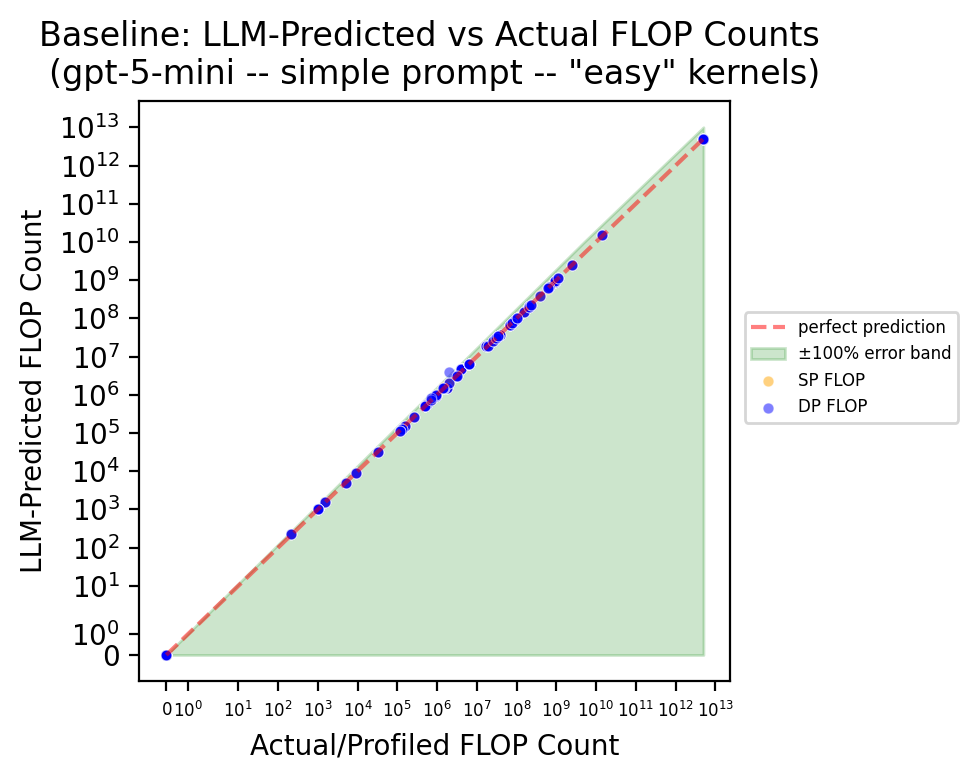

SP Percent Diff Described: 
count    606.000000
mean       0.400362
std        2.948844
min      -16.666343
25%        0.000000
50%        0.000000
75%        0.000000
max       19.855780
Name: percent_diff_sp, dtype: float64
 median: 0.0004383671871361595
DP Percent Diff Described: 
count    606.000000
mean       0.607758
std        5.058968
min      -16.666343
25%        0.000000
50%        0.000000
75%        0.000000
max       99.999504
Name: percent_diff_dp, dtype: float64
 median: 0.0005722078981498552


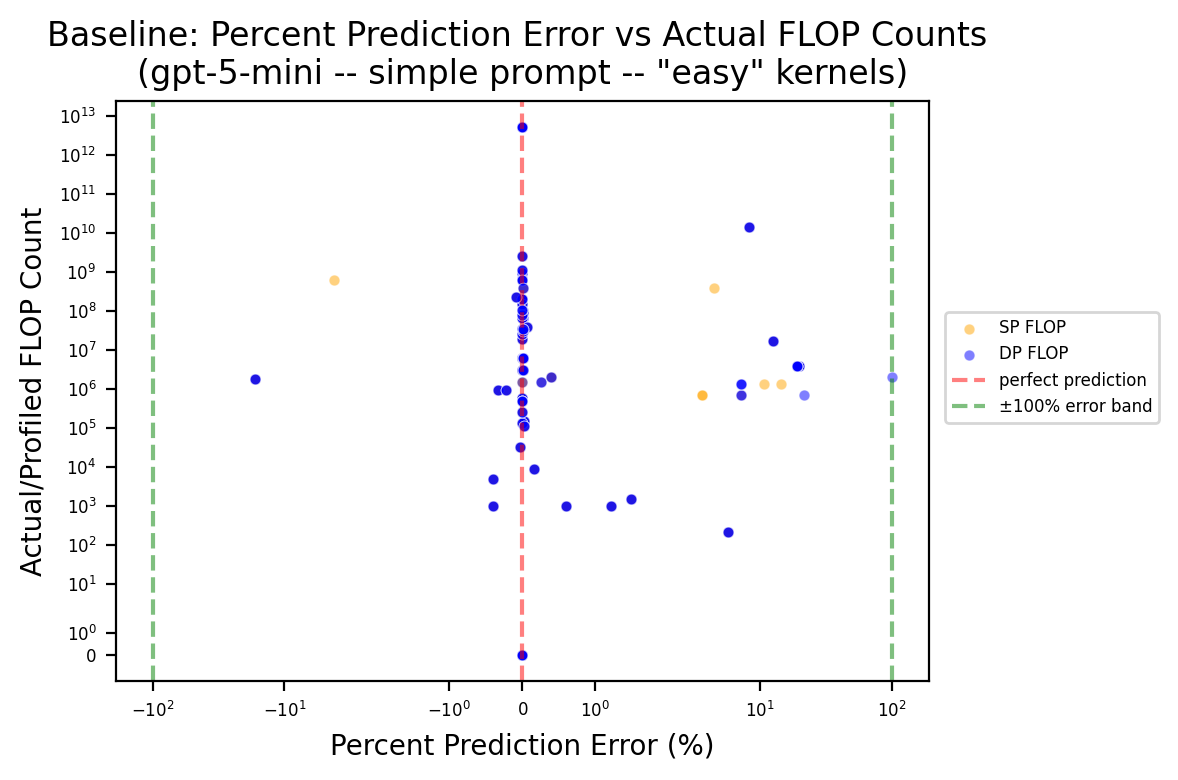

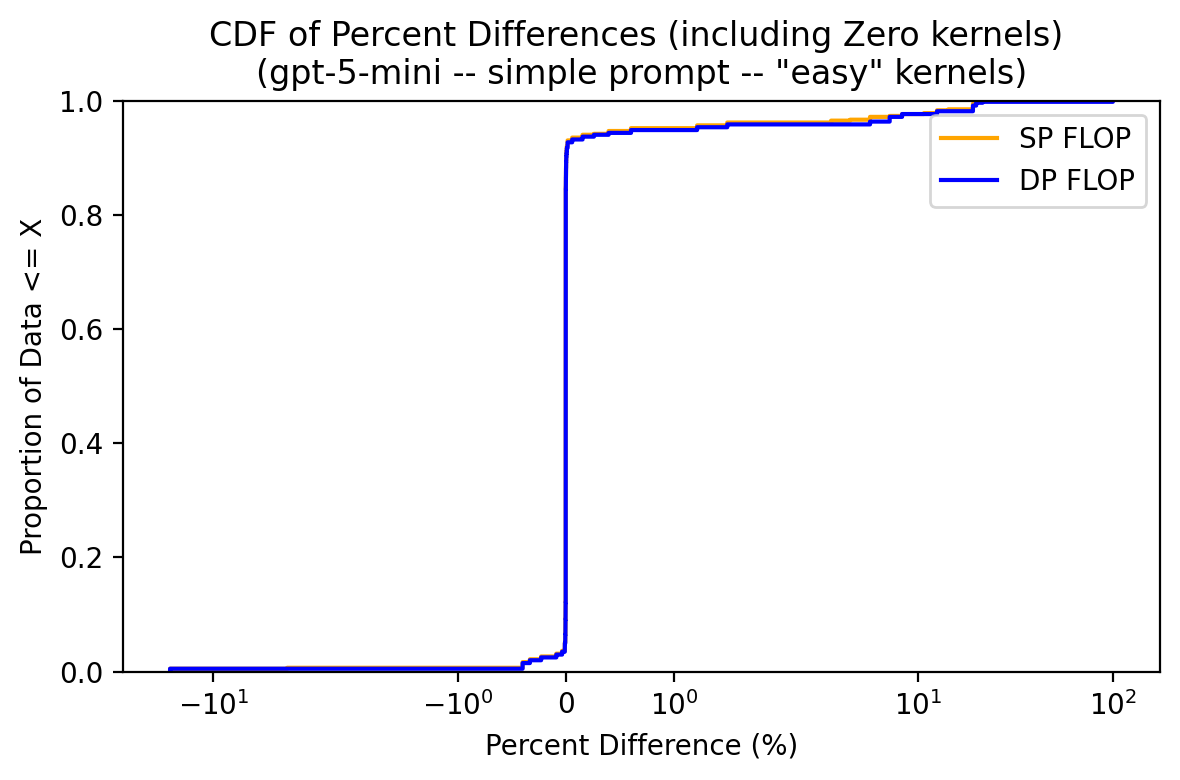

SP FLOP: 573 / 606 (94.55%) within +/- 1%
SP FLOP: 33 / 606 (5.45%) outside +/- 1%
DP FLOP: 572 / 606 (94.39%) within +/- 1%
DP FLOP: 34 / 606 (5.61%) outside +/- 1%


SP FLOP: 583 / 606 (96.20%) within +/- 5%
SP FLOP: 23 / 606 (3.80%) outside +/- 5%
DP FLOP: 578 / 606 (95.38%) within +/- 5%
DP FLOP: 28 / 606 (4.62%) outside +/- 5%


SP FLOP: 589 / 606 (97.19%) within +/- 10%
SP FLOP: 17 / 606 (2.81%) outside +/- 10%
DP FLOP: 589 / 606 (97.19%) within +/- 10%
DP FLOP: 17 / 606 (2.81%) outside +/- 10%


SP FLOP: 606 / 606 (100.00%) within +/- 50%
SP FLOP: 0 / 606 (0.00%) outside +/- 50%
DP FLOP: 605 / 606 (99.83%) within +/- 50%
DP FLOP: 1 / 606 (0.17%) outside +/- 50%


SP FLOP: 606 / 606 (100.00%) within +/- 75%
SP FLOP: 0 / 606 (0.00%) outside +/- 75%
DP FLOP: 605 / 606 (99.83%) within +/- 75%
DP FLOP: 1 / 606 (0.17%) outside +/- 75%


SP FLOP: 606 / 606 (100.00%) within +/- 99%
SP FLOP: 0 / 606 (0.00%) outside +/- 99%
DP FLOP: 605 / 606 (99.83%) within +/- 99%
DP FLOP: 1 / 606 (0.17

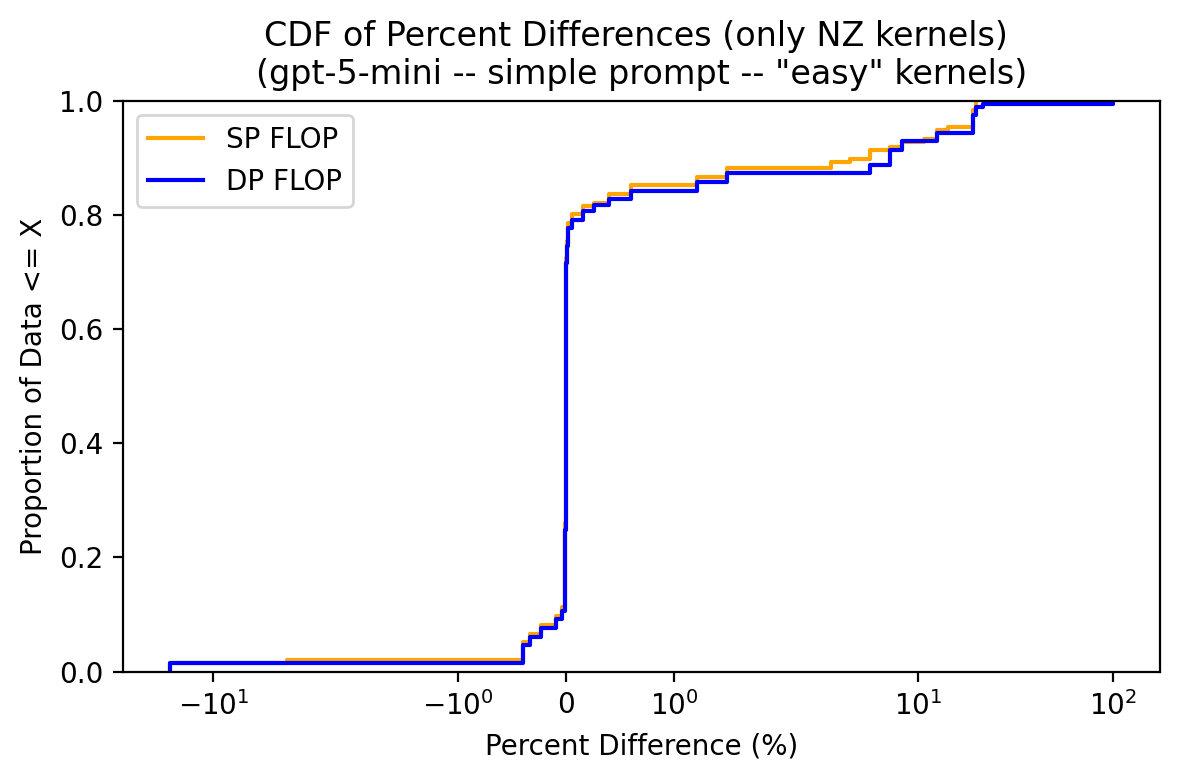

SP FLOP: 163 / 196 (83.16%) within +/- 1%
SP FLOP: 33 / 196 (16.84%) outside +/- 1%
DP FLOP: 163 / 197 (82.74%) within +/- 1%
DP FLOP: 34 / 197 (17.26%) outside +/- 1%


SP FLOP: 173 / 196 (88.27%) within +/- 5%
SP FLOP: 23 / 196 (11.73%) outside +/- 5%
DP FLOP: 169 / 197 (85.79%) within +/- 5%
DP FLOP: 28 / 197 (14.21%) outside +/- 5%


SP FLOP: 179 / 196 (91.33%) within +/- 10%
SP FLOP: 17 / 196 (8.67%) outside +/- 10%
DP FLOP: 180 / 197 (91.37%) within +/- 10%
DP FLOP: 17 / 197 (8.63%) outside +/- 10%


SP FLOP: 196 / 196 (100.00%) within +/- 50%
SP FLOP: 0 / 196 (0.00%) outside +/- 50%
DP FLOP: 196 / 197 (99.49%) within +/- 50%
DP FLOP: 1 / 197 (0.51%) outside +/- 50%


SP FLOP: 196 / 196 (100.00%) within +/- 75%
SP FLOP: 0 / 196 (0.00%) outside +/- 75%
DP FLOP: 196 / 197 (99.49%) within +/- 75%
DP FLOP: 1 / 197 (0.51%) outside +/- 75%


SP FLOP: 196 / 196 (100.00%) within +/- 99%
SP FLOP: 0 / 196 (0.00%) outside +/- 99%
DP FLOP: 196 / 197 (99.49%) within +/- 99%
DP FLOP: 1 / 197 (

/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_27639/4278730648.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  percent_str = percent_str.applymap(lambda x: f"{float(x):.2f}%")


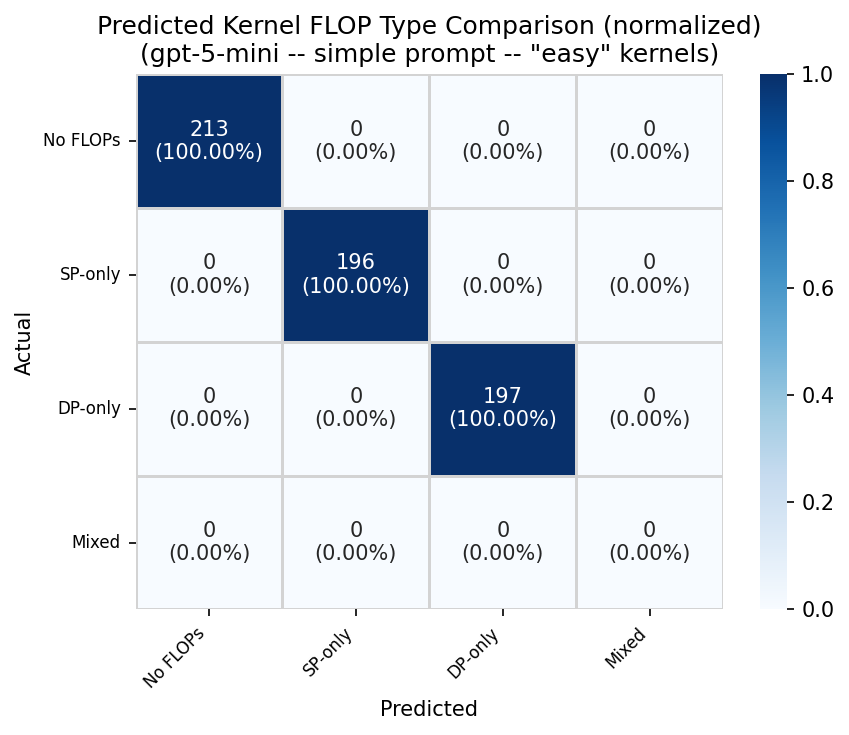

NZ SP Data Size: (196, 37)
NZ DP Data Size: (197, 37)
Mean Absolute Percent Difference SP: 1.84%
Mean Absolute Percent Difference DP: 2.42%
Median Absolute Percent Difference SP: 0.00%
Median Absolute Percent Difference DP: 0.00%
Mean Absolute Percent Difference SP (zero FLOP): 0.00%
Mean Absolute Percent Difference DP (zero FLOP): 0.00%
Median Absolute Percent Difference SP (zero FLOP): 0.00%
Median Absolute Percent Difference DP (zero FLOP): 0.00%


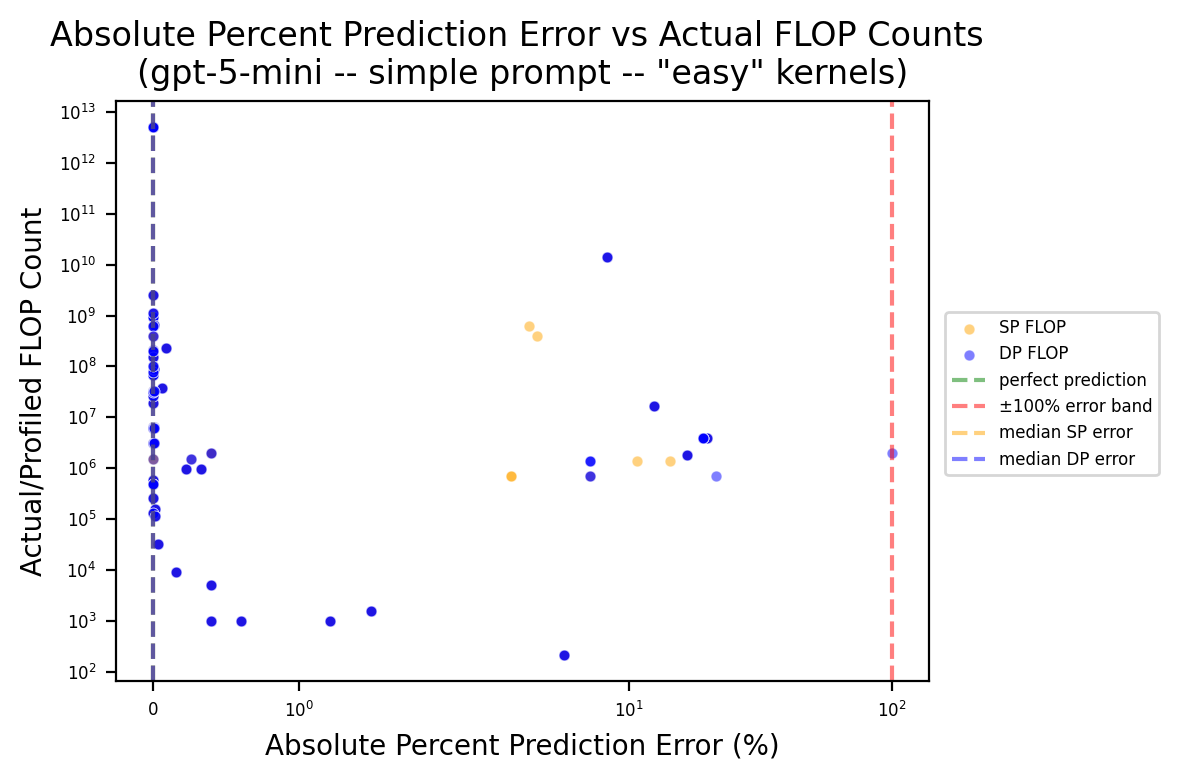

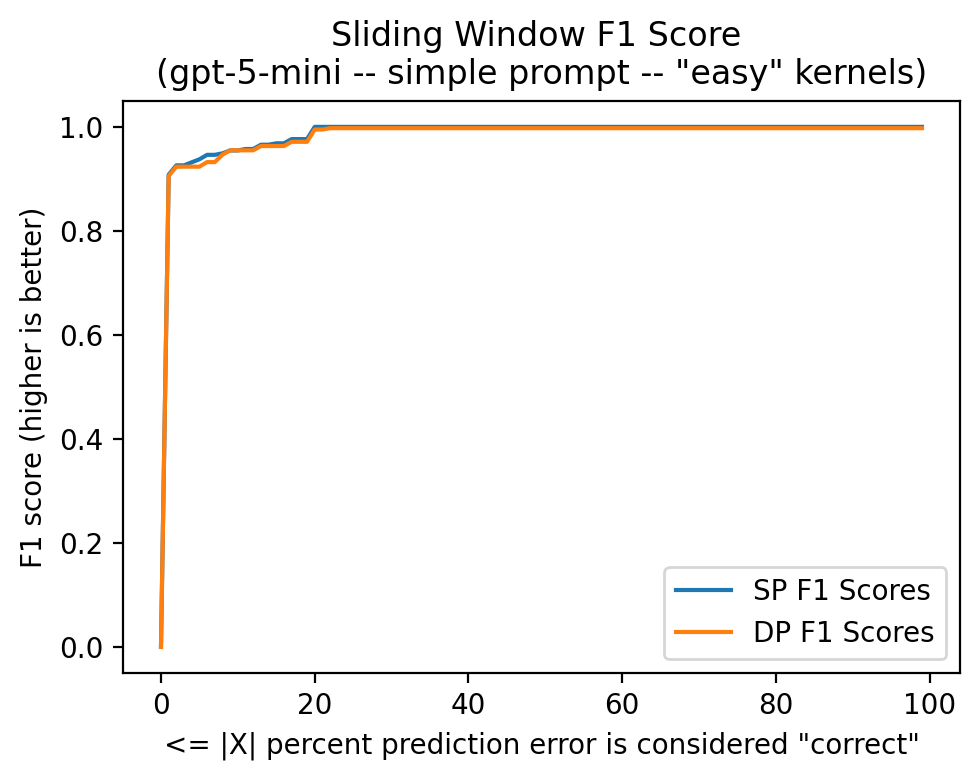

/Users/gbolet/miniconda3/envs/autogen5.7/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


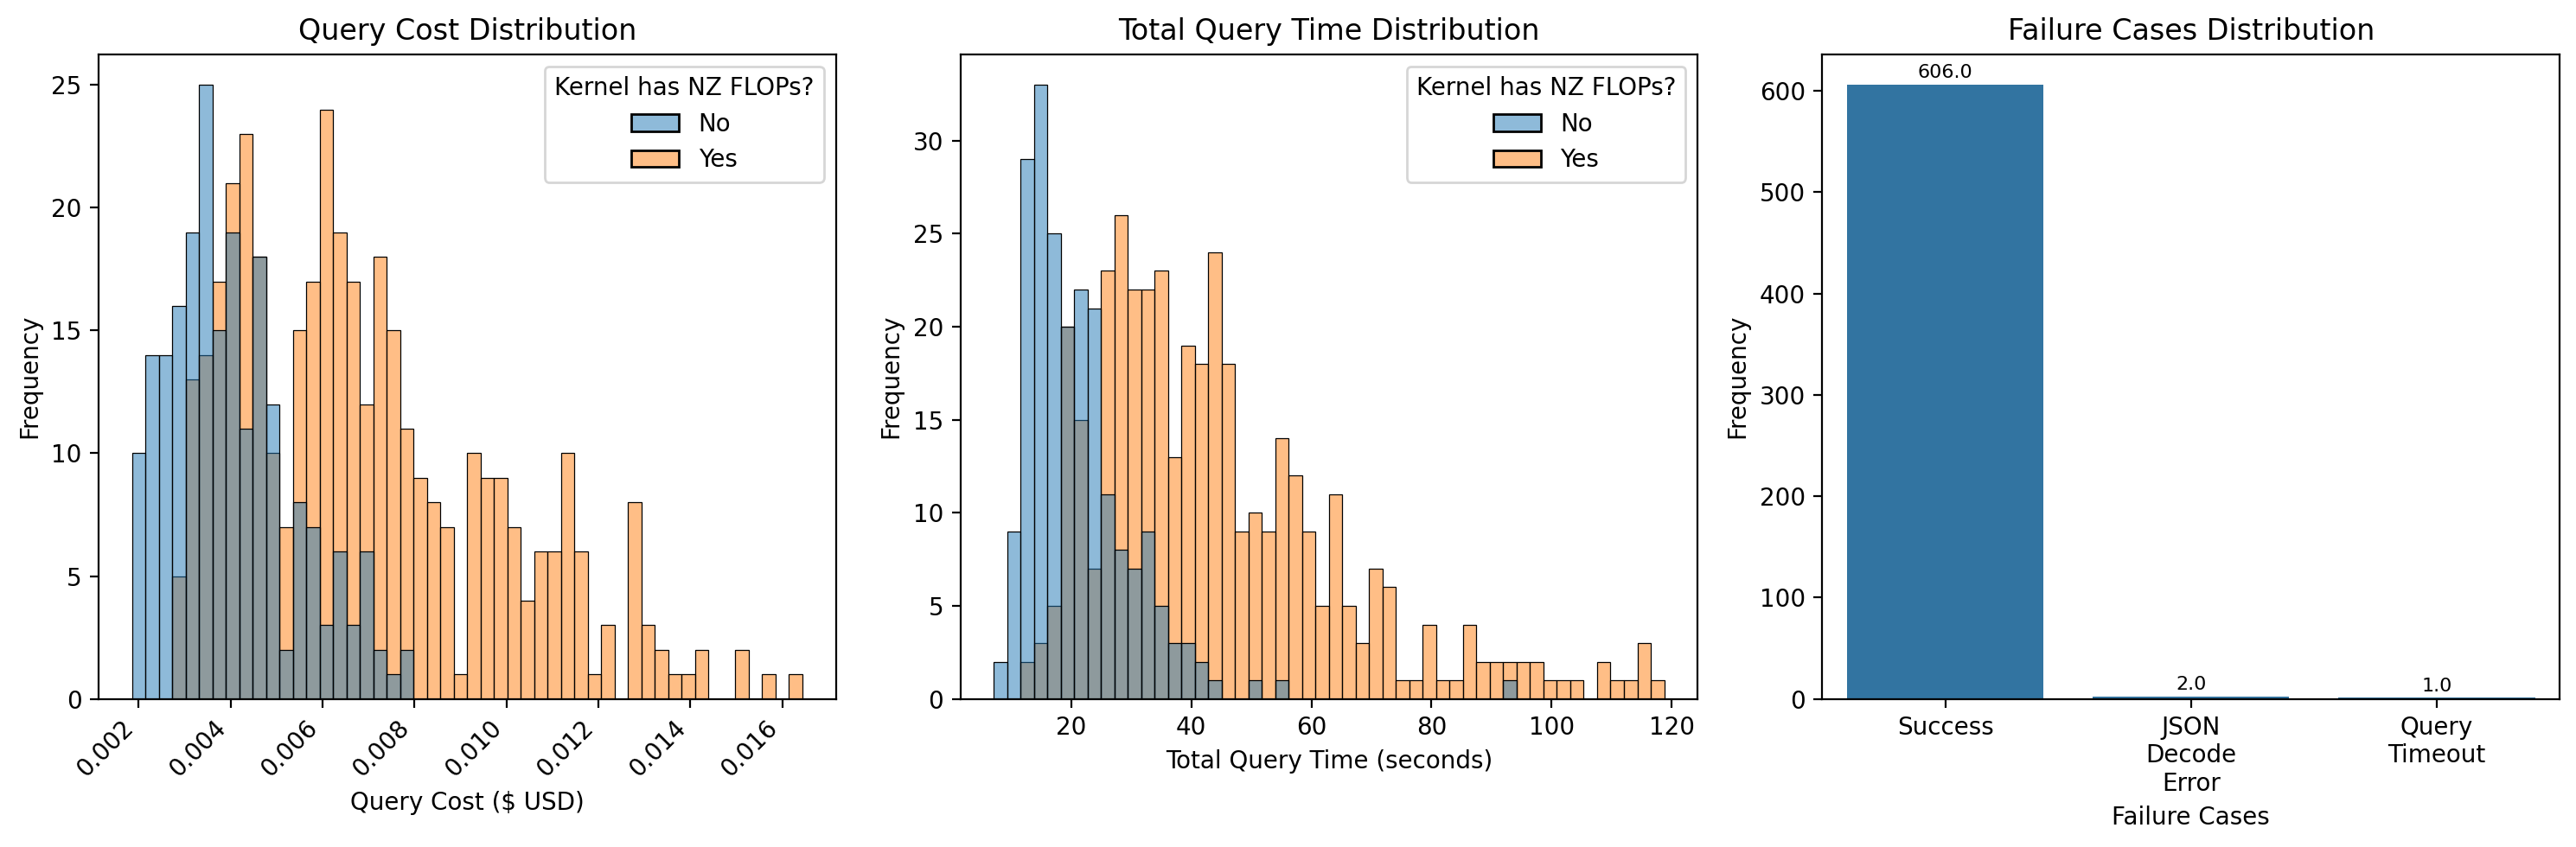

Success DF Size: (606, 36)


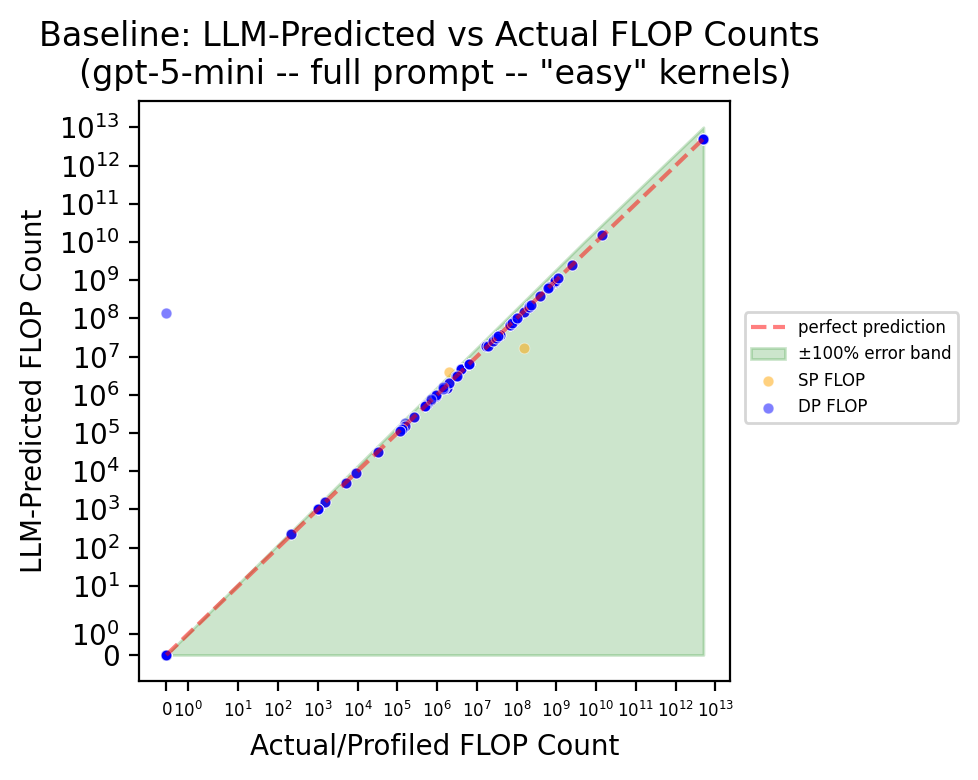

SP Percent Diff Described: 
count    606.000000
mean       0.410968
std        6.165704
min      -88.889072
25%        0.000000
50%        0.000000
75%        0.000000
max       99.999504
Name: percent_diff_sp, dtype: float64
 median: 0.0005722078981498552
DP Percent Diff Described: 
count    6.060000e+02
mean     2.214814e+16
std      5.452223e+17
min     -1.666634e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.342177e+19
Name: percent_diff_dp, dtype: float64
 median: 0.0005722078981498552


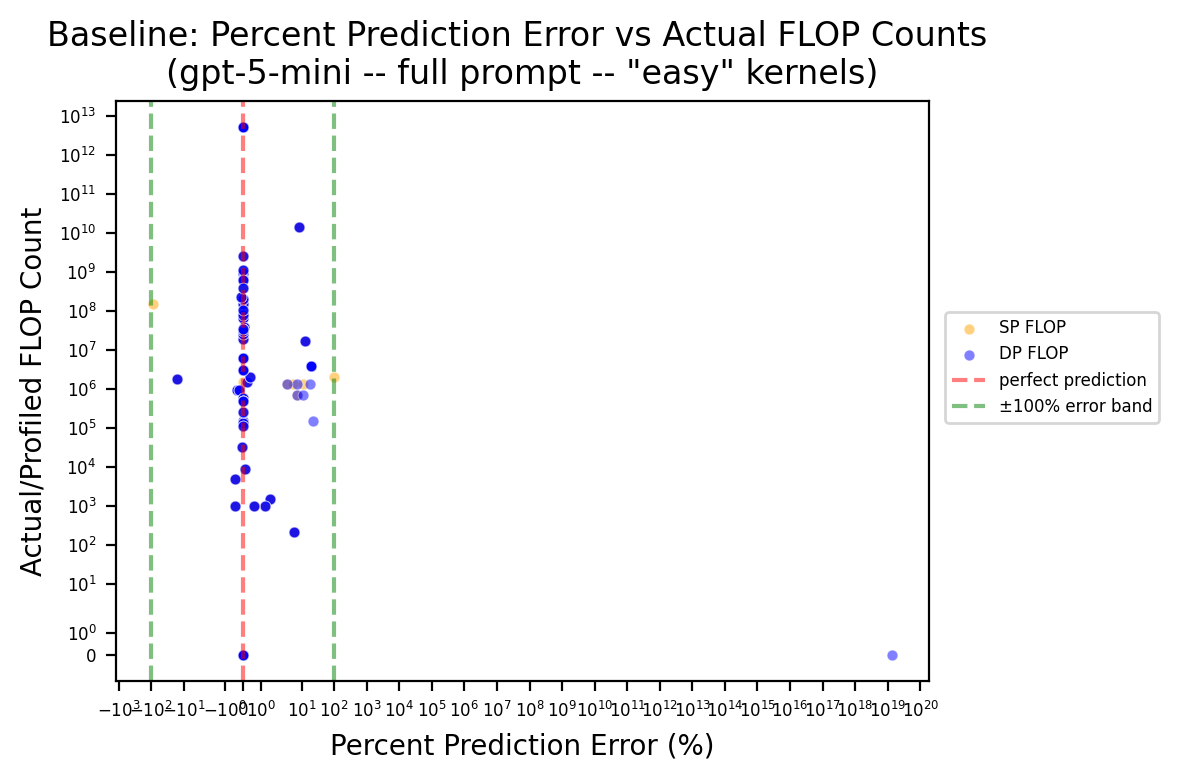

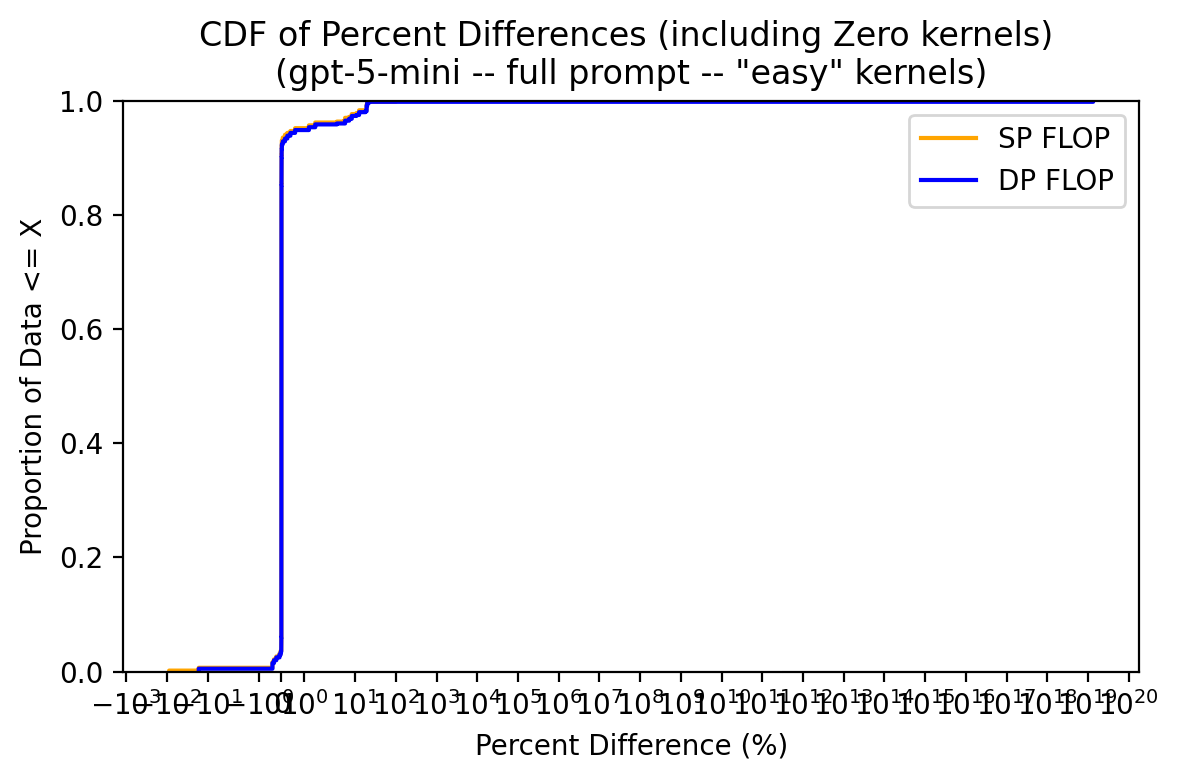

SP FLOP: 573 / 606 (94.55%) within +/- 1%
SP FLOP: 33 / 606 (5.45%) outside +/- 1%
DP FLOP: 572 / 606 (94.39%) within +/- 1%
DP FLOP: 34 / 606 (5.61%) outside +/- 1%


SP FLOP: 580 / 606 (95.71%) within +/- 5%
SP FLOP: 26 / 606 (4.29%) outside +/- 5%
DP FLOP: 579 / 606 (95.54%) within +/- 5%
DP FLOP: 27 / 606 (4.46%) outside +/- 5%


SP FLOP: 588 / 606 (97.03%) within +/- 10%
SP FLOP: 18 / 606 (2.97%) outside +/- 10%
DP FLOP: 587 / 606 (96.86%) within +/- 10%
DP FLOP: 19 / 606 (3.14%) outside +/- 10%


SP FLOP: 604 / 606 (99.67%) within +/- 50%
SP FLOP: 2 / 606 (0.33%) outside +/- 50%
DP FLOP: 605 / 606 (99.83%) within +/- 50%
DP FLOP: 1 / 606 (0.17%) outside +/- 50%


SP FLOP: 604 / 606 (99.67%) within +/- 75%
SP FLOP: 2 / 606 (0.33%) outside +/- 75%
DP FLOP: 605 / 606 (99.83%) within +/- 75%
DP FLOP: 1 / 606 (0.17%) outside +/- 75%


SP FLOP: 605 / 606 (99.83%) within +/- 99%
SP FLOP: 1 / 606 (0.17%) outside +/- 99%
DP FLOP: 605 / 606 (99.83%) within +/- 99%
DP FLOP: 1 / 606 (0.17%) 

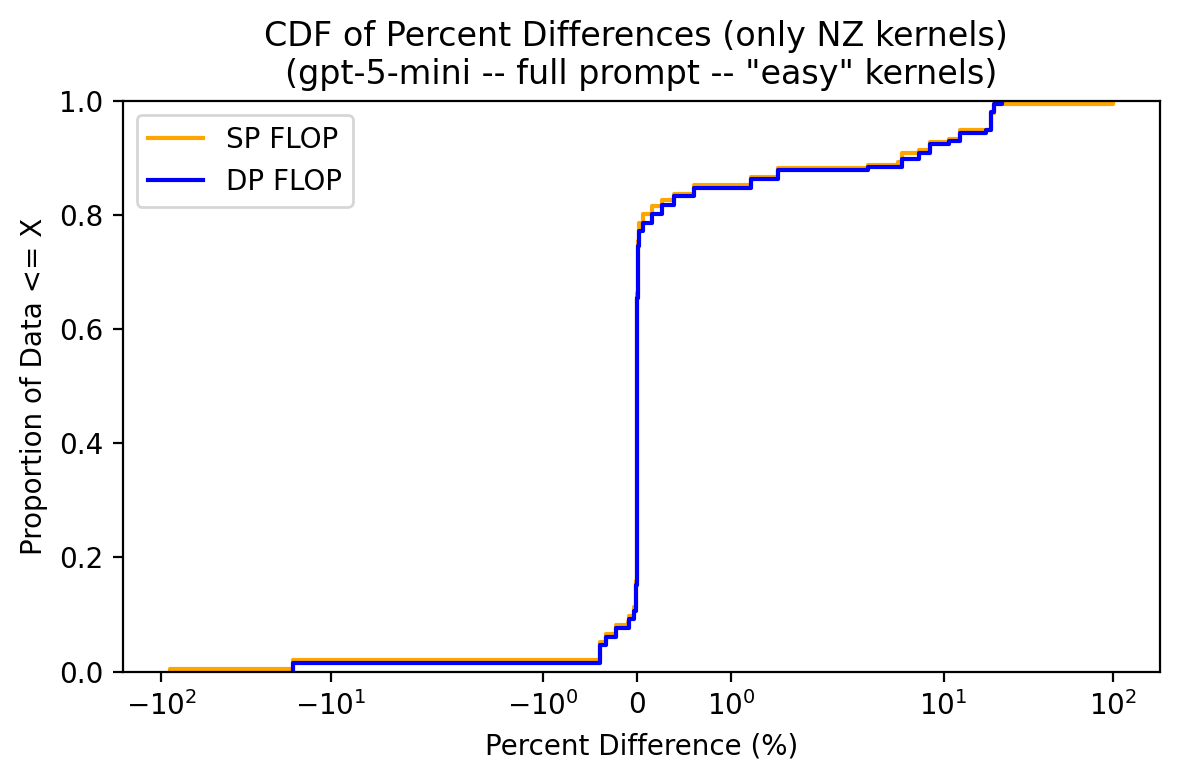

SP FLOP: 163 / 196 (83.16%) within +/- 1%
SP FLOP: 33 / 196 (16.84%) outside +/- 1%
DP FLOP: 164 / 197 (83.25%) within +/- 1%
DP FLOP: 33 / 197 (16.75%) outside +/- 1%


SP FLOP: 170 / 196 (86.73%) within +/- 5%
SP FLOP: 26 / 196 (13.27%) outside +/- 5%
DP FLOP: 171 / 197 (86.80%) within +/- 5%
DP FLOP: 26 / 197 (13.20%) outside +/- 5%


SP FLOP: 178 / 196 (90.82%) within +/- 10%
SP FLOP: 18 / 196 (9.18%) outside +/- 10%
DP FLOP: 179 / 197 (90.86%) within +/- 10%
DP FLOP: 18 / 197 (9.14%) outside +/- 10%


SP FLOP: 194 / 196 (98.98%) within +/- 50%
SP FLOP: 2 / 196 (1.02%) outside +/- 50%
DP FLOP: 197 / 197 (100.00%) within +/- 50%
DP FLOP: 0 / 197 (0.00%) outside +/- 50%


SP FLOP: 194 / 196 (98.98%) within +/- 75%
SP FLOP: 2 / 196 (1.02%) outside +/- 75%
DP FLOP: 197 / 197 (100.00%) within +/- 75%
DP FLOP: 0 / 197 (0.00%) outside +/- 75%


SP FLOP: 195 / 196 (99.49%) within +/- 99%
SP FLOP: 1 / 196 (0.51%) outside +/- 99%
DP FLOP: 197 / 197 (100.00%) within +/- 99%
DP FLOP: 0 / 197 (

/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_27639/4278730648.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  percent_str = percent_str.applymap(lambda x: f"{float(x):.2f}%")


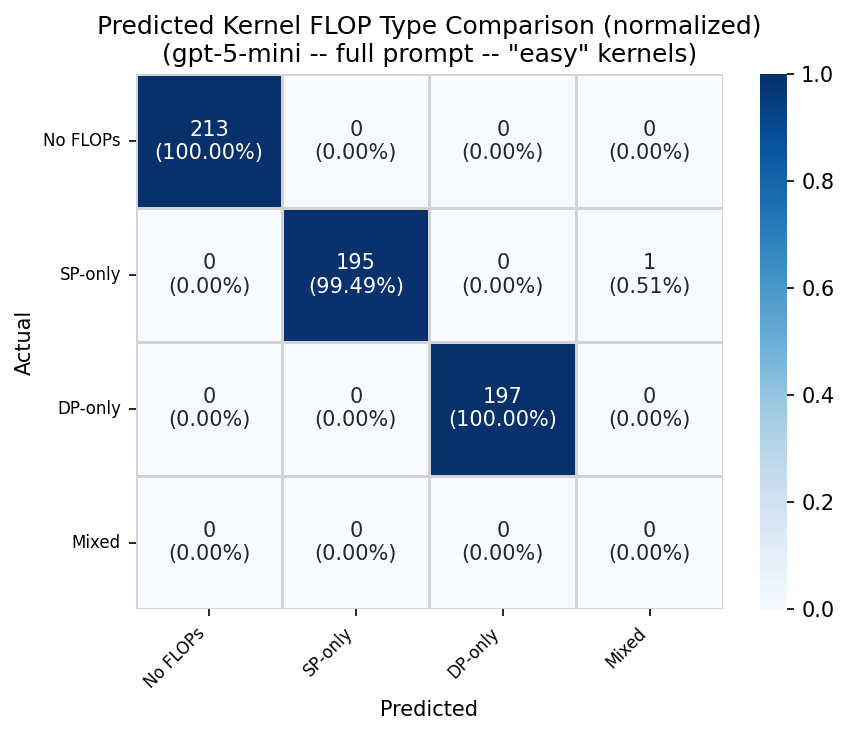

NZ SP Data Size: (196, 37)
NZ DP Data Size: (197, 37)
Mean Absolute Percent Difference SP: 2.73%
Mean Absolute Percent Difference DP: 1.98%
Median Absolute Percent Difference SP: 0.00%
Median Absolute Percent Difference DP: 0.00%
Mean Absolute Percent Difference SP (zero FLOP): 0.00%
Mean Absolute Percent Difference DP (zero FLOP): 32816070415647920.00%
Median Absolute Percent Difference SP (zero FLOP): 0.00%
Median Absolute Percent Difference DP (zero FLOP): 0.00%


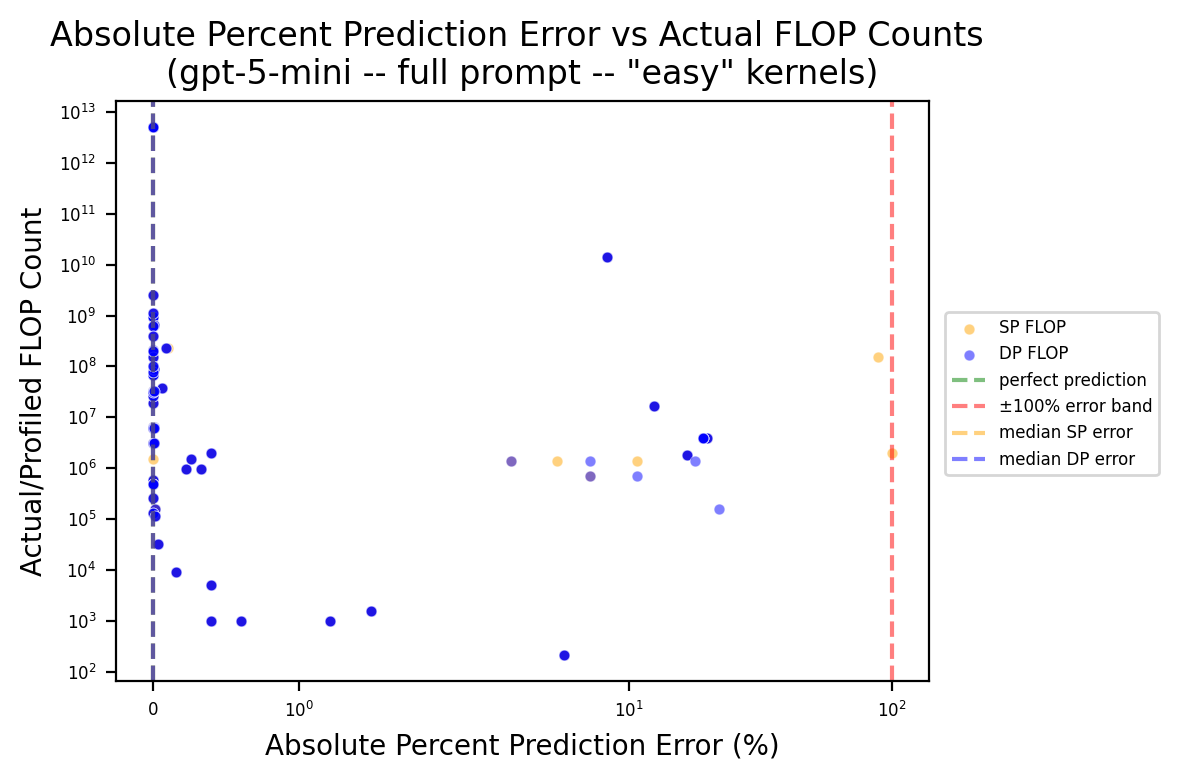

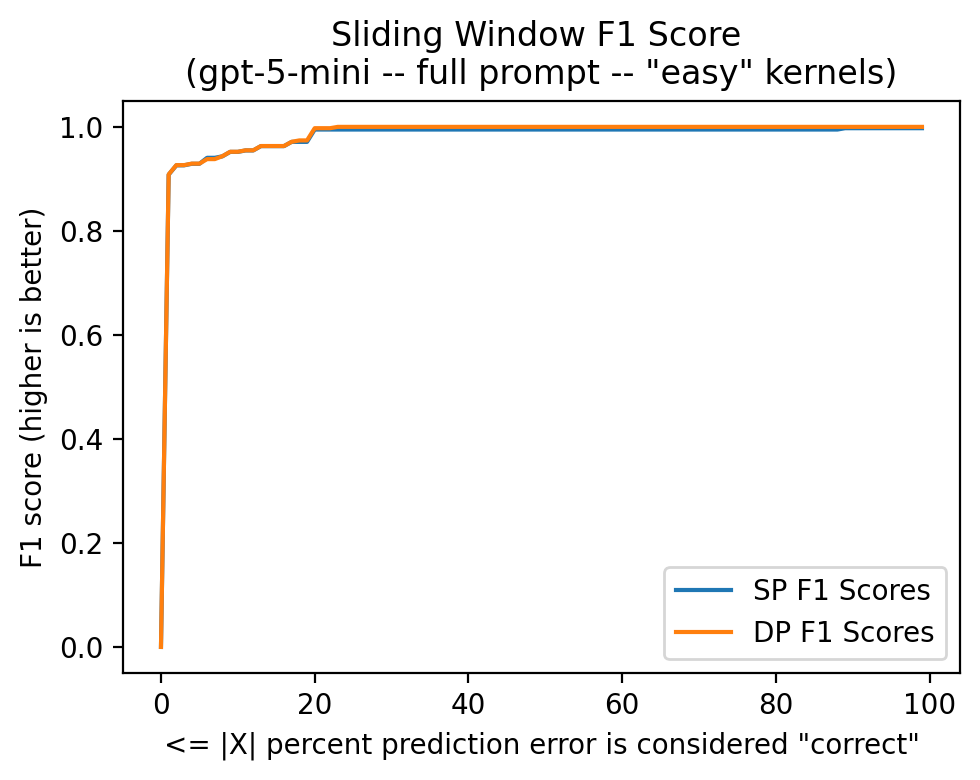

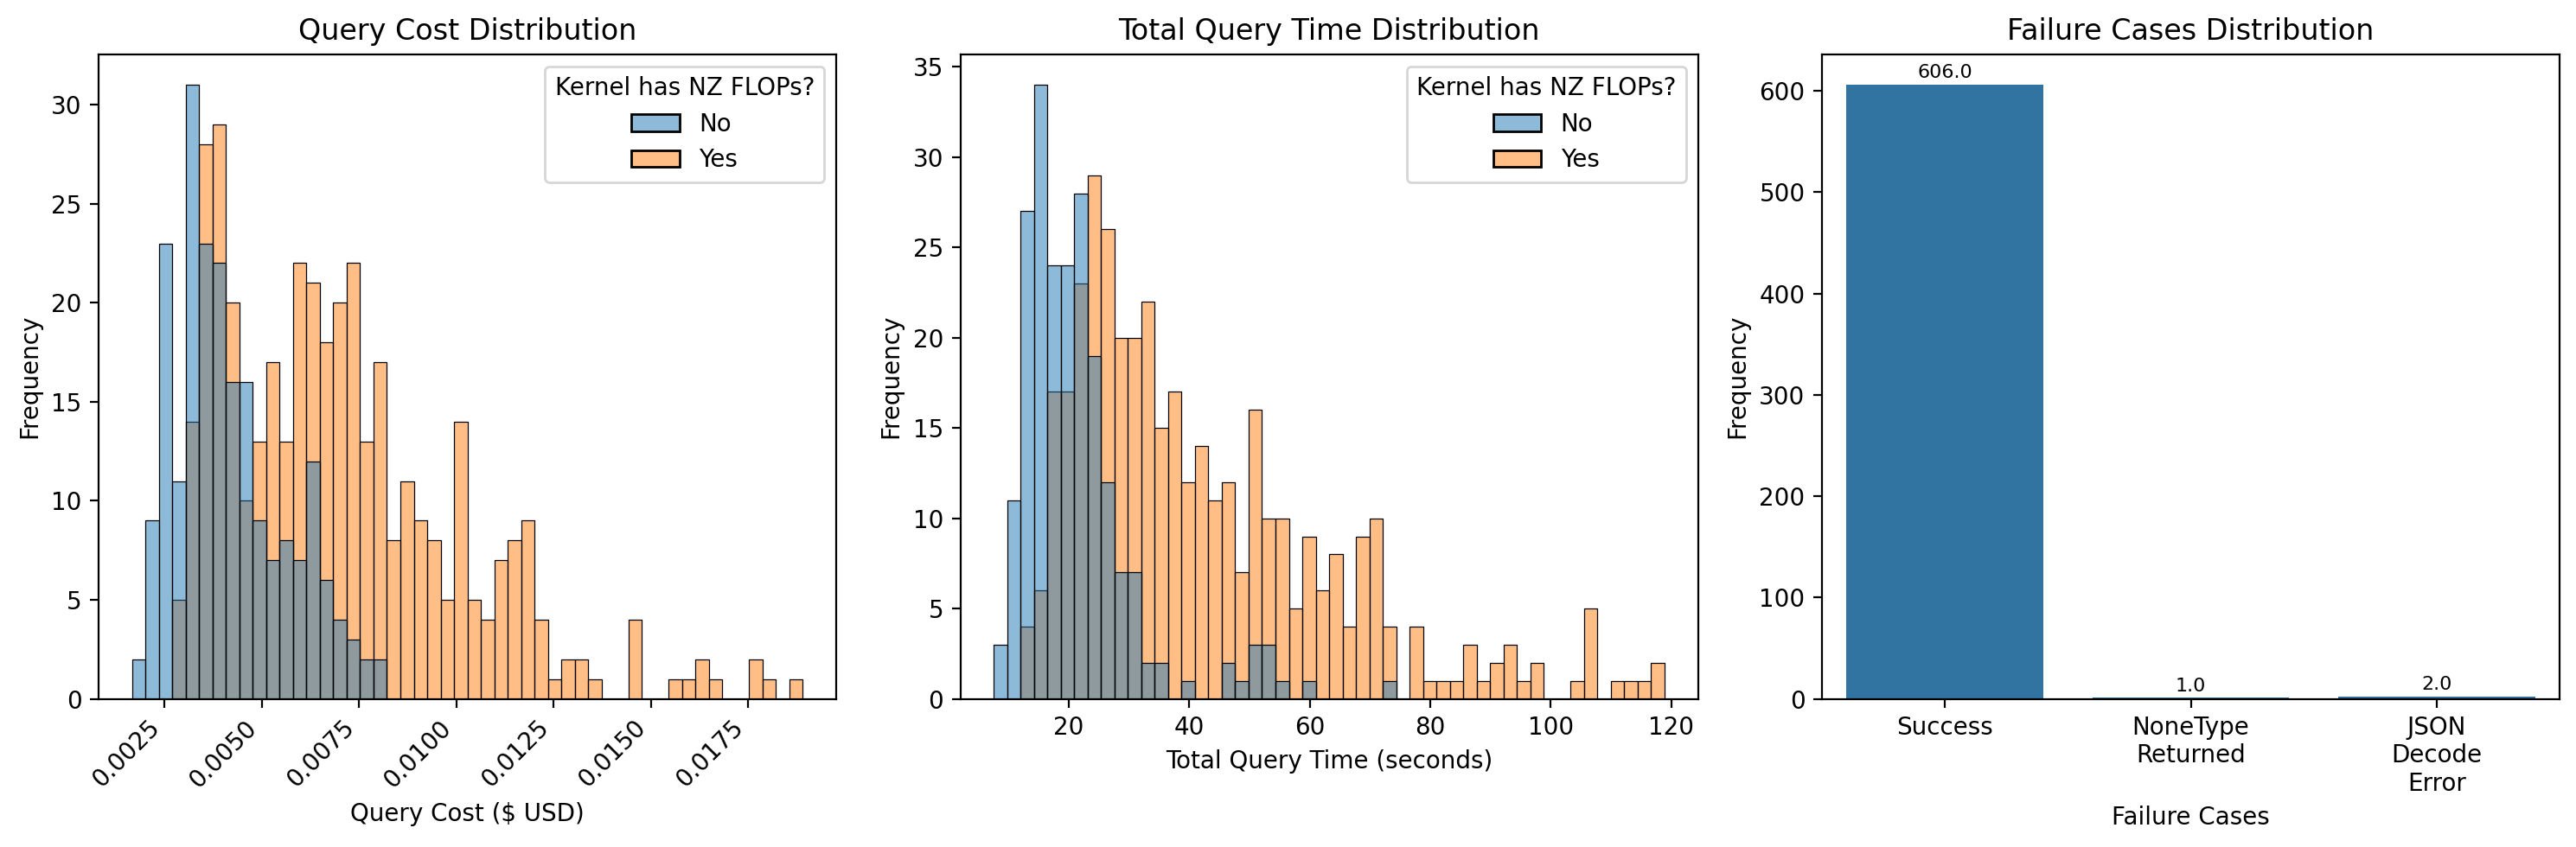

Success DF Size: (1008, 36)


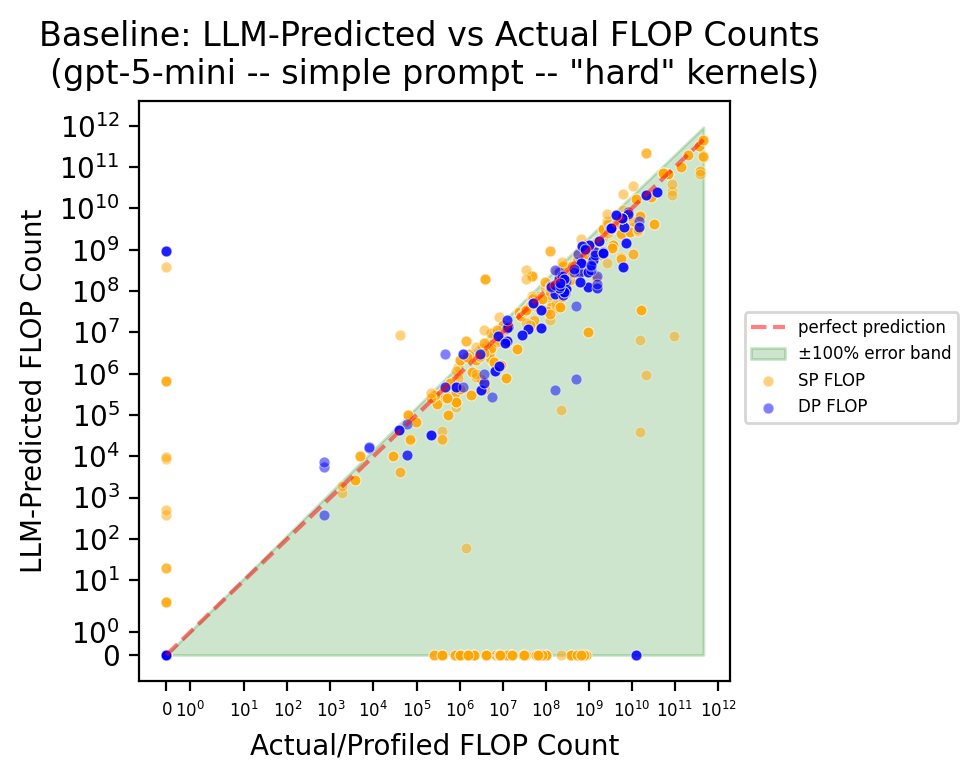

SP Percent Diff Described: 
count    1.008000e+03
mean     3.848376e+16
std      1.215394e+18
min     -1.000000e+02
25%     -5.624828e+01
50%      0.000000e+00
75%      0.000000e+00
max      3.858760e+19
Name: percent_diff_sp, dtype: float64
 median: -51.82070882128244
DP Percent Diff Described: 
count    1.008000e+03
mean     2.745600e+17
std      5.027768e+18
min     -1.000000e+02
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.225216e+19
Name: percent_diff_dp, dtype: float64
 median: -43.750647746447044


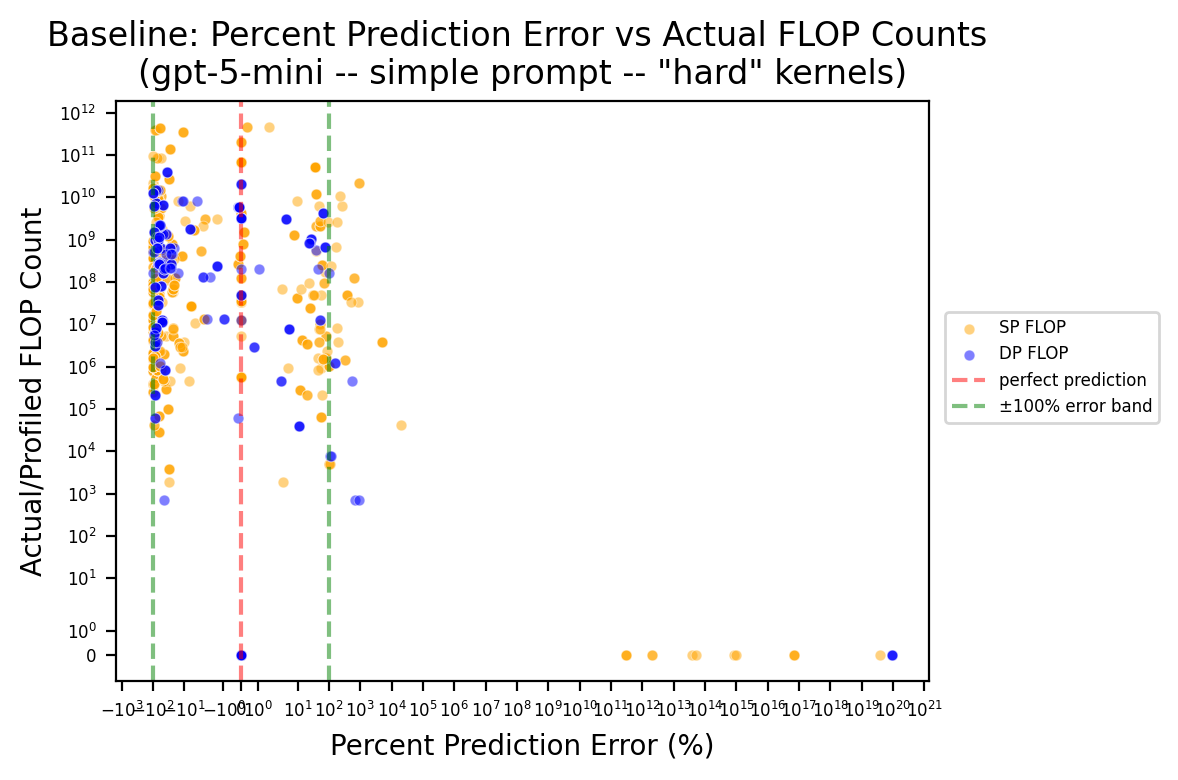

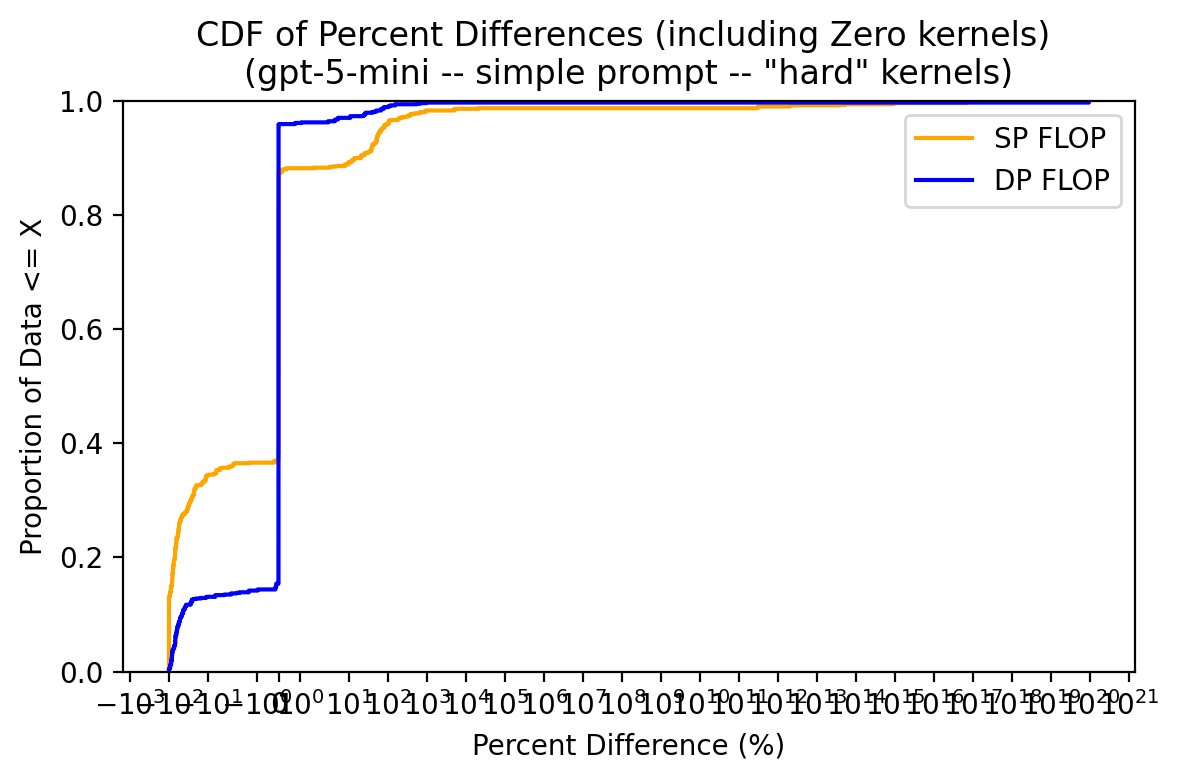

SP FLOP: 520 / 1008 (51.59%) within +/- 1%
SP FLOP: 488 / 1008 (48.41%) outside +/- 1%
DP FLOP: 826 / 1008 (81.94%) within +/- 1%
DP FLOP: 182 / 1008 (18.06%) outside +/- 1%


SP FLOP: 537 / 1008 (53.27%) within +/- 5%
SP FLOP: 471 / 1008 (46.73%) outside +/- 5%
DP FLOP: 840 / 1008 (83.33%) within +/- 5%
DP FLOP: 168 / 1008 (16.67%) outside +/- 5%


SP FLOP: 553 / 1008 (54.86%) within +/- 10%
SP FLOP: 455 / 1008 (45.14%) outside +/- 10%
DP FLOP: 846 / 1008 (83.93%) within +/- 10%
DP FLOP: 162 / 1008 (16.07%) outside +/- 10%


SP FLOP: 671 / 1008 (66.57%) within +/- 50%
SP FLOP: 337 / 1008 (33.43%) outside +/- 50%
DP FLOP: 894 / 1008 (88.69%) within +/- 50%
DP FLOP: 114 / 1008 (11.31%) outside +/- 50%


SP FLOP: 767 / 1008 (76.09%) within +/- 75%
SP FLOP: 241 / 1008 (23.91%) outside +/- 75%
DP FLOP: 953 / 1008 (94.54%) within +/- 75%
DP FLOP: 55 / 1008 (5.46%) outside +/- 75%


SP FLOP: 837 / 1008 (83.04%) within +/- 99%
SP FLOP: 171 / 1008 (16.96%) outside +/- 99%
DP FLOP: 993 / 1008 (

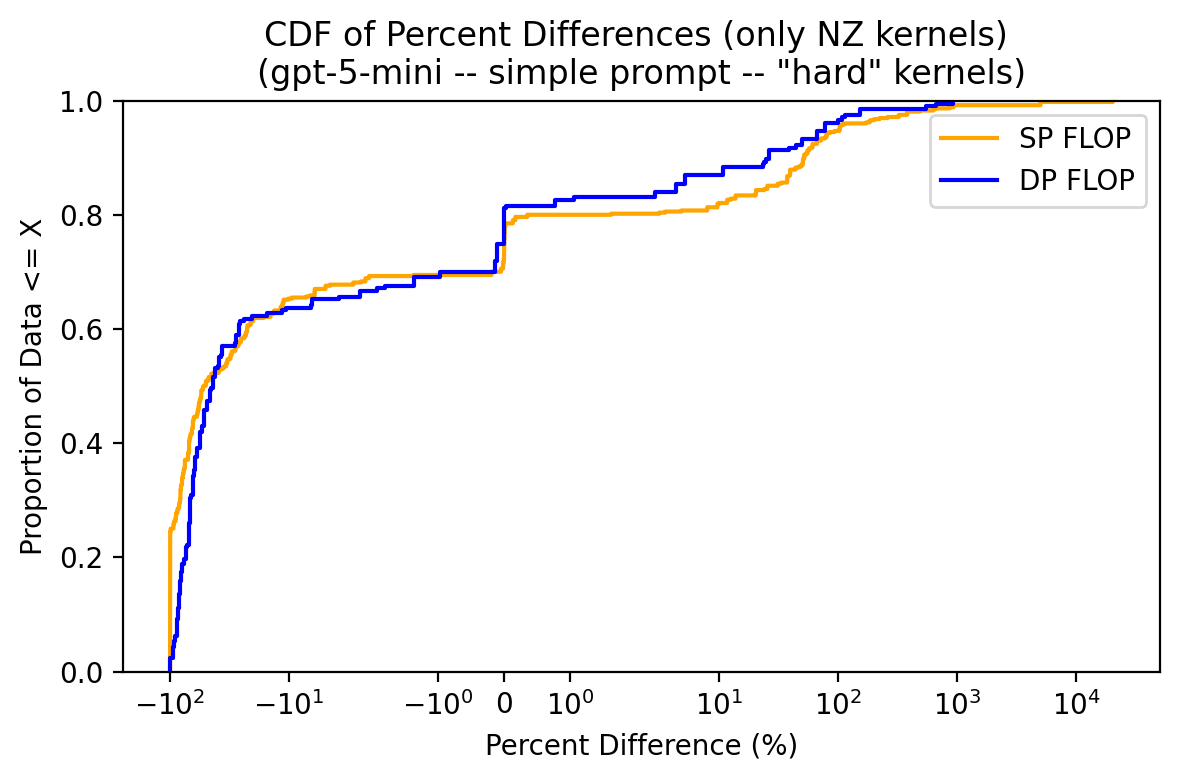

SP FLOP: 56 / 531 (10.55%) within +/- 1%
SP FLOP: 475 / 531 (89.45%) outside +/- 1%
DP FLOP: 28 / 207 (13.53%) within +/- 1%
DP FLOP: 179 / 207 (86.47%) outside +/- 1%


SP FLOP: 73 / 531 (13.75%) within +/- 5%
SP FLOP: 458 / 531 (86.25%) outside +/- 5%
DP FLOP: 42 / 207 (20.29%) within +/- 5%
DP FLOP: 165 / 207 (79.71%) outside +/- 5%


SP FLOP: 89 / 531 (16.76%) within +/- 10%
SP FLOP: 442 / 531 (83.24%) outside +/- 10%
DP FLOP: 48 / 207 (23.19%) within +/- 10%
DP FLOP: 159 / 207 (76.81%) outside +/- 10%


SP FLOP: 207 / 531 (38.98%) within +/- 50%
SP FLOP: 324 / 531 (61.02%) outside +/- 50%
DP FLOP: 96 / 207 (46.38%) within +/- 50%
DP FLOP: 111 / 207 (53.62%) outside +/- 50%


SP FLOP: 303 / 531 (57.06%) within +/- 75%
SP FLOP: 228 / 531 (42.94%) outside +/- 75%
DP FLOP: 155 / 207 (74.88%) within +/- 75%
DP FLOP: 52 / 207 (25.12%) outside +/- 75%


SP FLOP: 373 / 531 (70.24%) within +/- 99%
SP FLOP: 158 / 531 (29.76%) outside +/- 99%
DP FLOP: 195 / 207 (94.20%) within +/- 99%
DP FLO

/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_27639/4278730648.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  percent_str = percent_str.applymap(lambda x: f"{float(x):.2f}%")


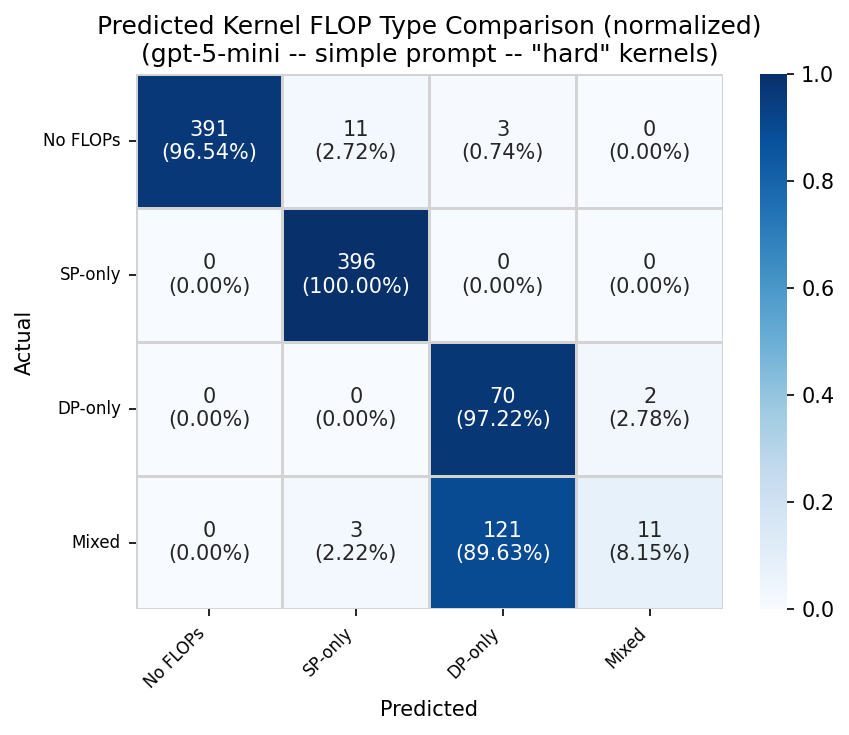

NZ SP Data Size: (531, 37)
NZ DP Data Size: (207, 37)
Mean Absolute Percent Difference SP: 135.58%
Mean Absolute Percent Difference DP: 57.65%
Median Absolute Percent Difference SP: 65.28%
Median Absolute Percent Difference DP: 52.17%
Mean Absolute Percent Difference SP (zero FLOP): 81324165408805024.00%
Mean Absolute Percent Difference DP (zero FLOP): 345513707865168512.00%
Median Absolute Percent Difference SP (zero FLOP): 0.00%
Median Absolute Percent Difference DP (zero FLOP): 0.00%


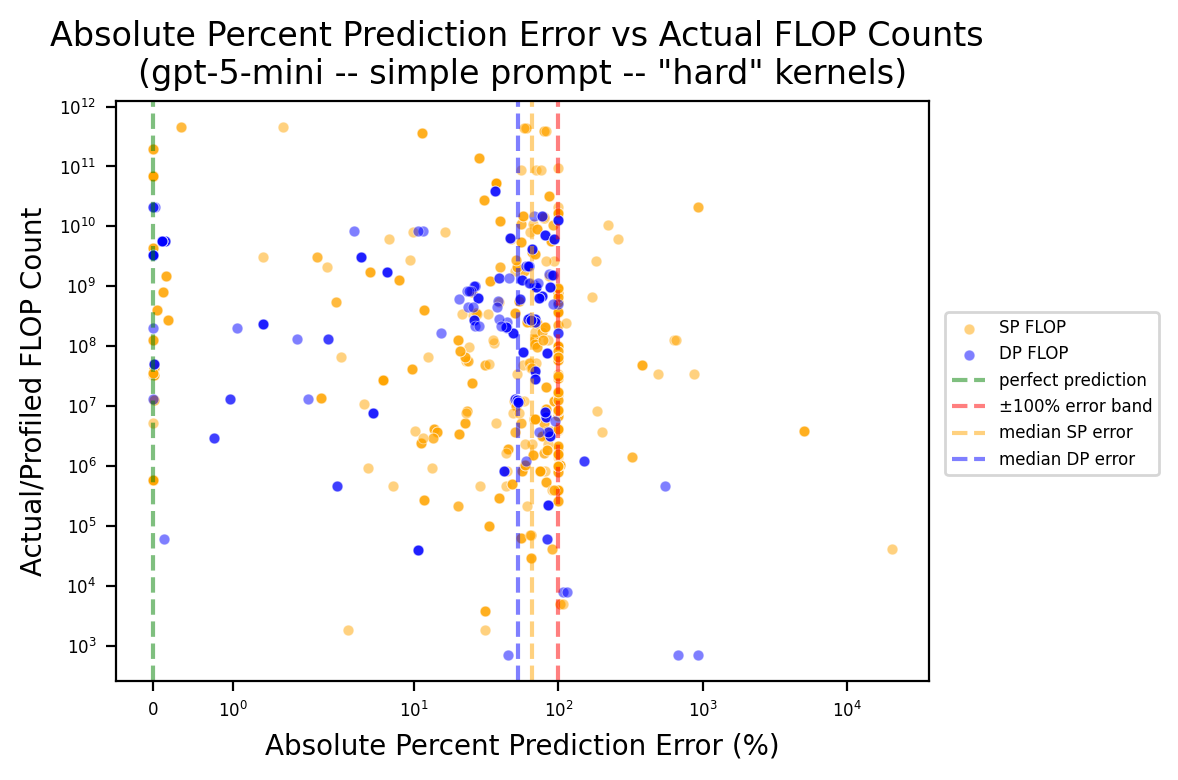

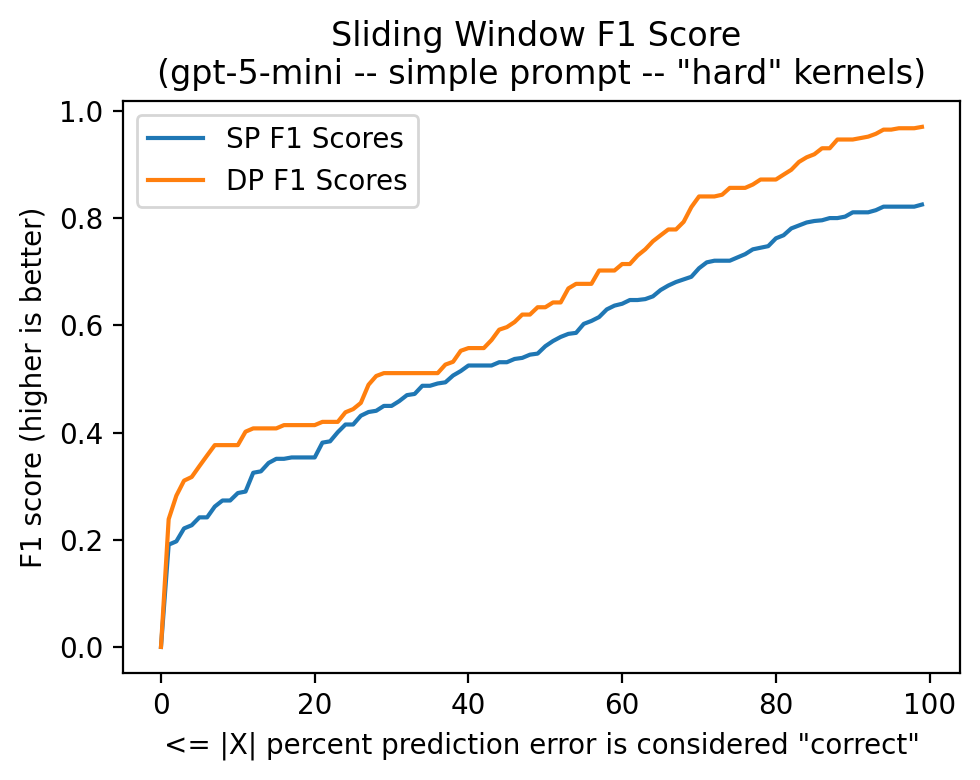

/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_27639/3290629337.py:81: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


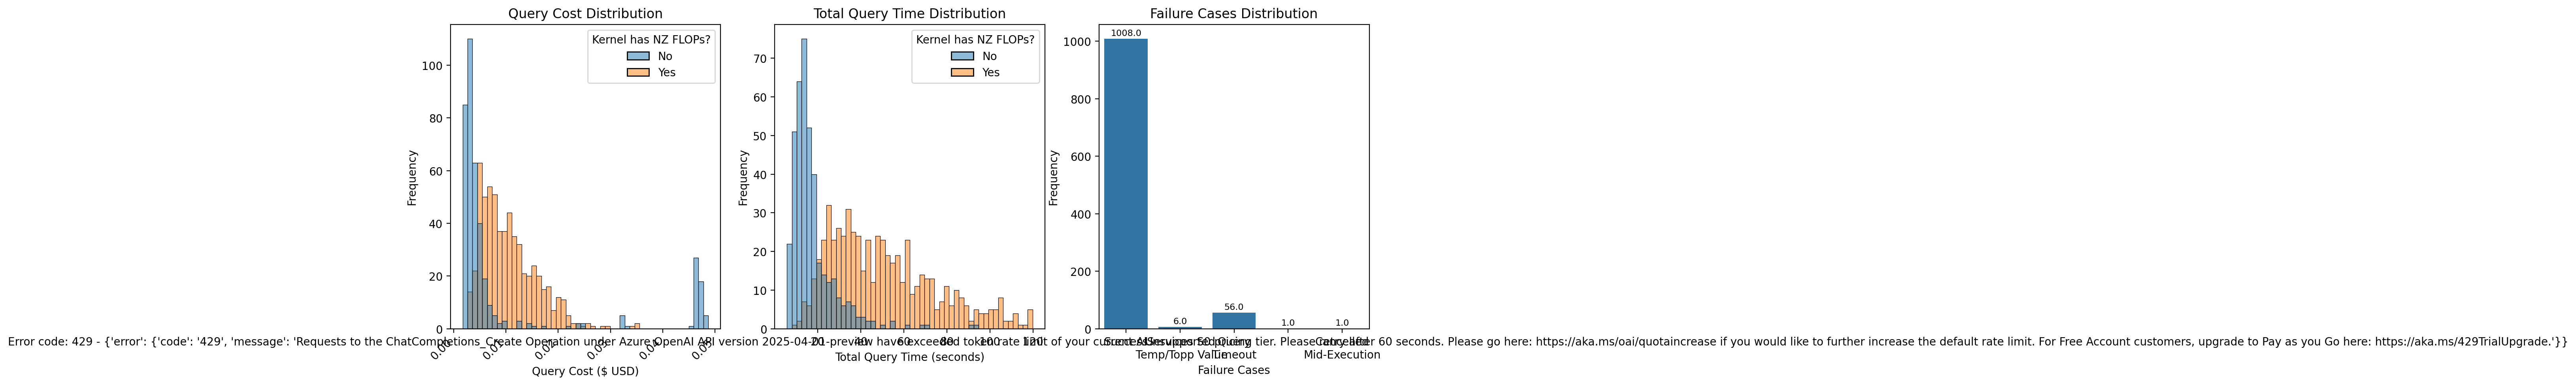

Success DF Size: (1014, 36)


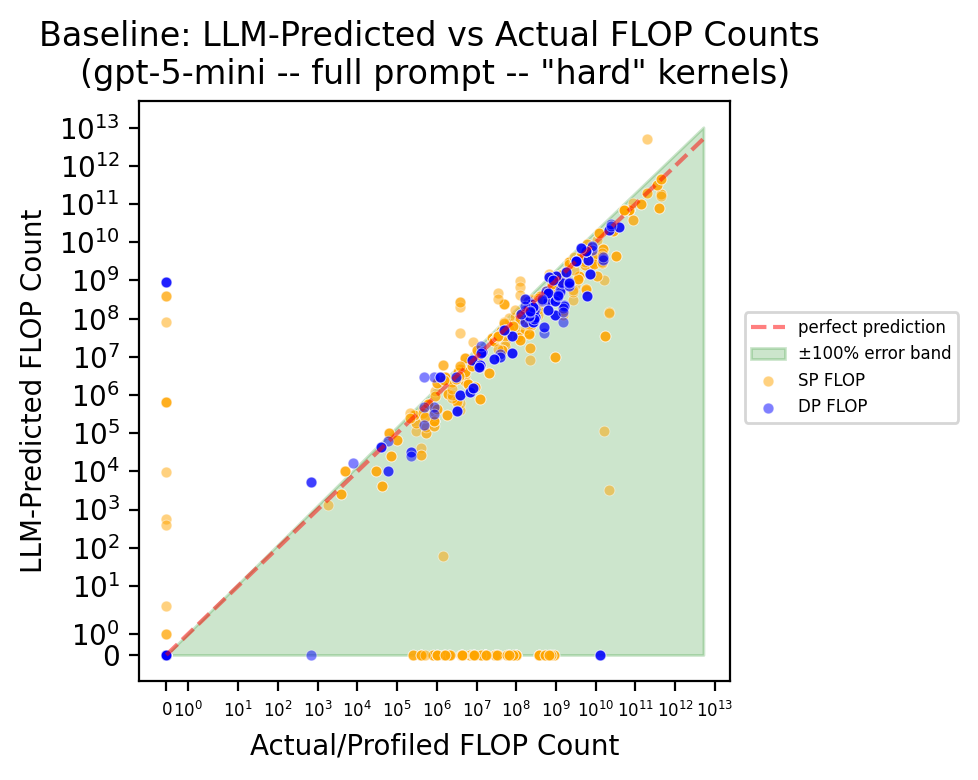

SP Percent Diff Described: 
count    1.014000e+03
mean     8.436182e+16
std      1.731612e+18
min     -1.000000e+02
25%     -5.937919e+01
50%      0.000000e+00
75%      0.000000e+00
max      3.858760e+19
Name: percent_diff_sp, dtype: float64
 median: -54.64044026056859
DP Percent Diff Described: 
count    1.014000e+03
mean     2.729354e+17
std      5.012900e+18
min     -1.000000e+02
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.225216e+19
Name: percent_diff_dp, dtype: float64
 median: -44.4476178258481


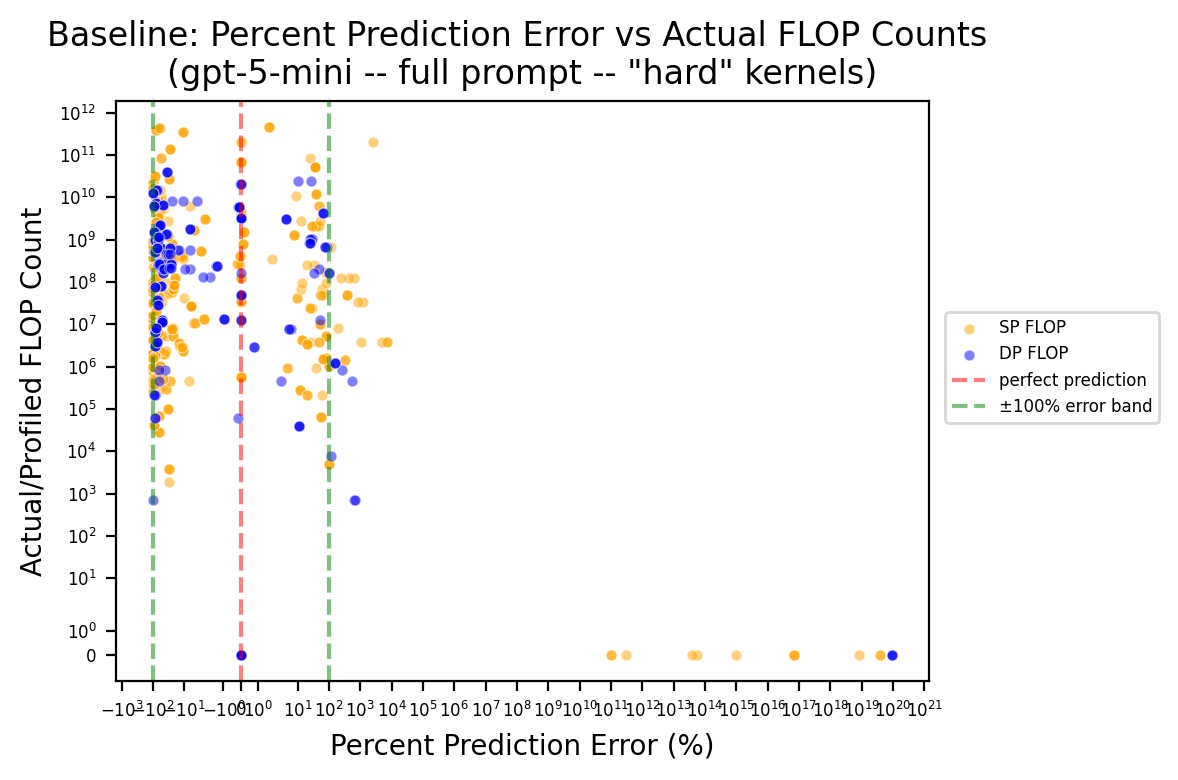

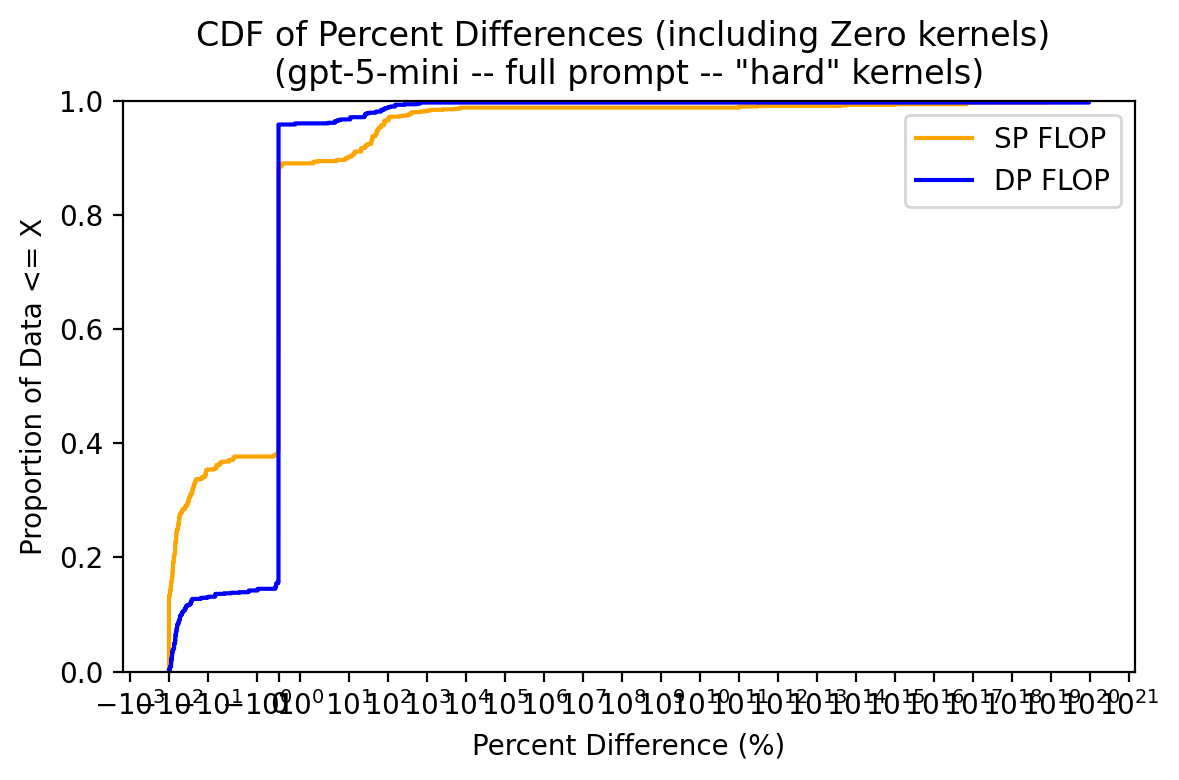

SP FLOP: 521 / 1014 (51.38%) within +/- 1%
SP FLOP: 493 / 1014 (48.62%) outside +/- 1%
DP FLOP: 830 / 1014 (81.85%) within +/- 1%
DP FLOP: 184 / 1014 (18.15%) outside +/- 1%


SP FLOP: 541 / 1014 (53.35%) within +/- 5%
SP FLOP: 473 / 1014 (46.65%) outside +/- 5%
DP FLOP: 840 / 1014 (82.84%) within +/- 5%
DP FLOP: 174 / 1014 (17.16%) outside +/- 5%


SP FLOP: 556 / 1014 (54.83%) within +/- 10%
SP FLOP: 458 / 1014 (45.17%) outside +/- 10%
DP FLOP: 849 / 1014 (83.73%) within +/- 10%
DP FLOP: 165 / 1014 (16.27%) outside +/- 10%


SP FLOP: 676 / 1014 (66.67%) within +/- 50%
SP FLOP: 338 / 1014 (33.33%) outside +/- 50%
DP FLOP: 895 / 1014 (88.26%) within +/- 50%
DP FLOP: 119 / 1014 (11.74%) outside +/- 50%


SP FLOP: 773 / 1014 (76.23%) within +/- 75%
SP FLOP: 241 / 1014 (23.77%) outside +/- 75%
DP FLOP: 957 / 1014 (94.38%) within +/- 75%
DP FLOP: 57 / 1014 (5.62%) outside +/- 75%


SP FLOP: 847 / 1014 (83.53%) within +/- 99%
SP FLOP: 167 / 1014 (16.47%) outside +/- 99%
DP FLOP: 997 / 1014 (

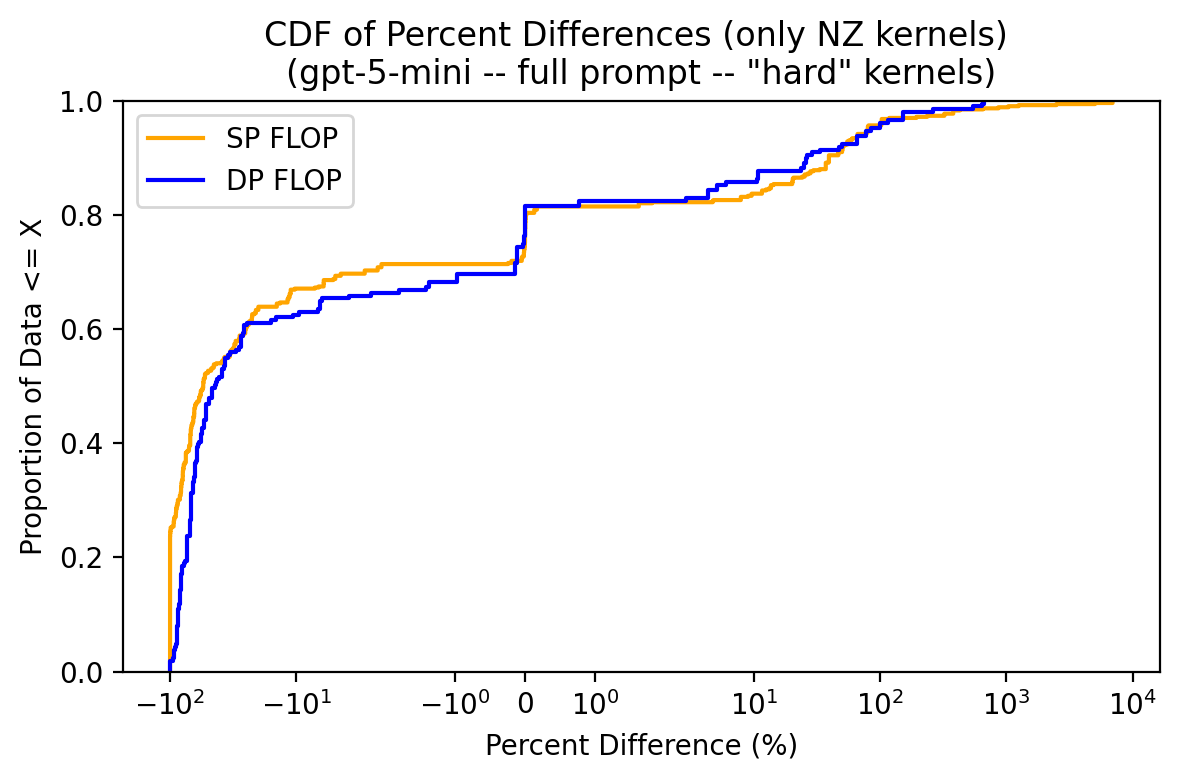

SP FLOP: 54 / 535 (10.09%) within +/- 1%
SP FLOP: 481 / 535 (89.91%) outside +/- 1%
DP FLOP: 30 / 211 (14.22%) within +/- 1%
DP FLOP: 181 / 211 (85.78%) outside +/- 1%


SP FLOP: 74 / 535 (13.83%) within +/- 5%
SP FLOP: 461 / 535 (86.17%) outside +/- 5%
DP FLOP: 40 / 211 (18.96%) within +/- 5%
DP FLOP: 171 / 211 (81.04%) outside +/- 5%


SP FLOP: 89 / 535 (16.64%) within +/- 10%
SP FLOP: 446 / 535 (83.36%) outside +/- 10%
DP FLOP: 49 / 211 (23.22%) within +/- 10%
DP FLOP: 162 / 211 (76.78%) outside +/- 10%


SP FLOP: 209 / 535 (39.07%) within +/- 50%
SP FLOP: 326 / 535 (60.93%) outside +/- 50%
DP FLOP: 95 / 211 (45.02%) within +/- 50%
DP FLOP: 116 / 211 (54.98%) outside +/- 50%


SP FLOP: 306 / 535 (57.20%) within +/- 75%
SP FLOP: 229 / 535 (42.80%) outside +/- 75%
DP FLOP: 157 / 211 (74.41%) within +/- 75%
DP FLOP: 54 / 211 (25.59%) outside +/- 75%


SP FLOP: 380 / 535 (71.03%) within +/- 99%
SP FLOP: 155 / 535 (28.97%) outside +/- 99%
DP FLOP: 197 / 211 (93.36%) within +/- 99%
DP FLO

/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_27639/4278730648.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  percent_str = percent_str.applymap(lambda x: f"{float(x):.2f}%")


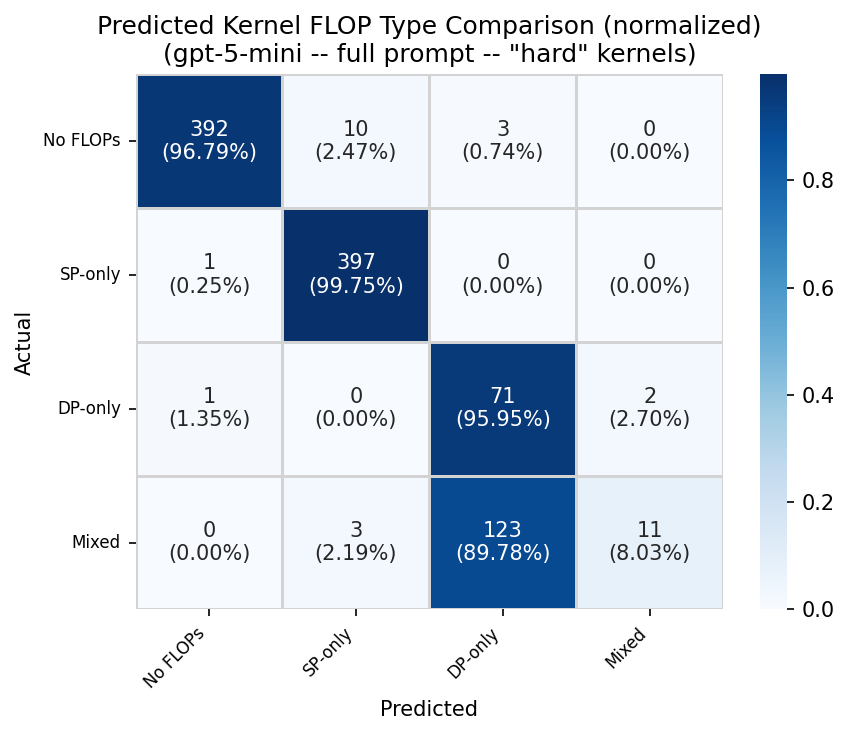

NZ SP Data Size: (535, 37)
NZ DP Data Size: (211, 37)
Mean Absolute Percent Difference SP: 107.55%
Mean Absolute Percent Difference DP: 57.70%
Median Absolute Percent Difference SP: 65.96%
Median Absolute Percent Difference DP: 56.00%
Mean Absolute Percent Difference SP (zero FLOP): 178586405219206688.00%
Mean Absolute Percent Difference DP (zero FLOP): 344653150684931520.00%
Median Absolute Percent Difference SP (zero FLOP): 0.00%
Median Absolute Percent Difference DP (zero FLOP): 0.00%


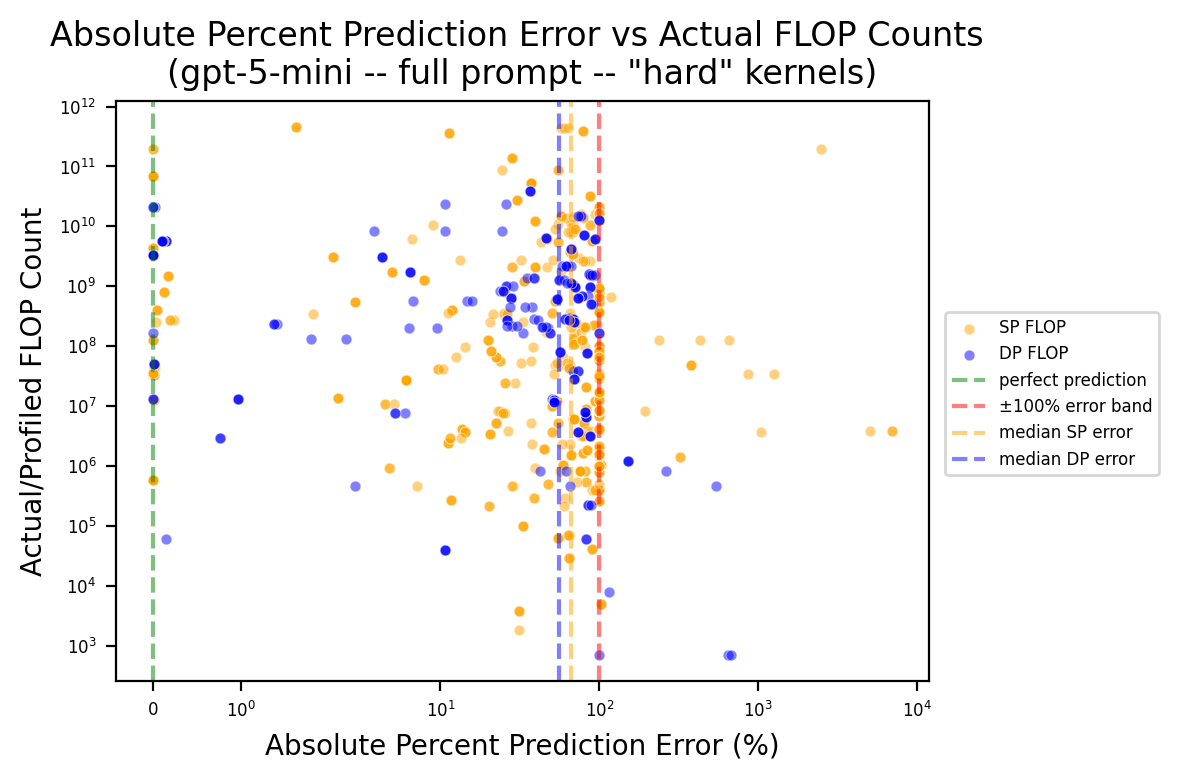

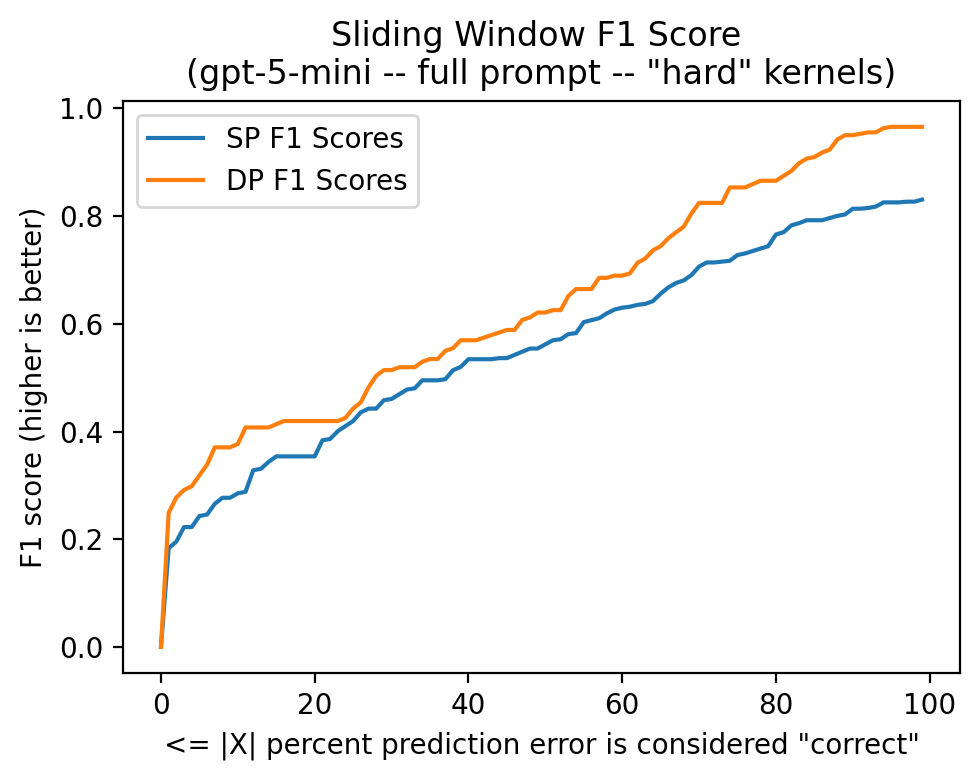

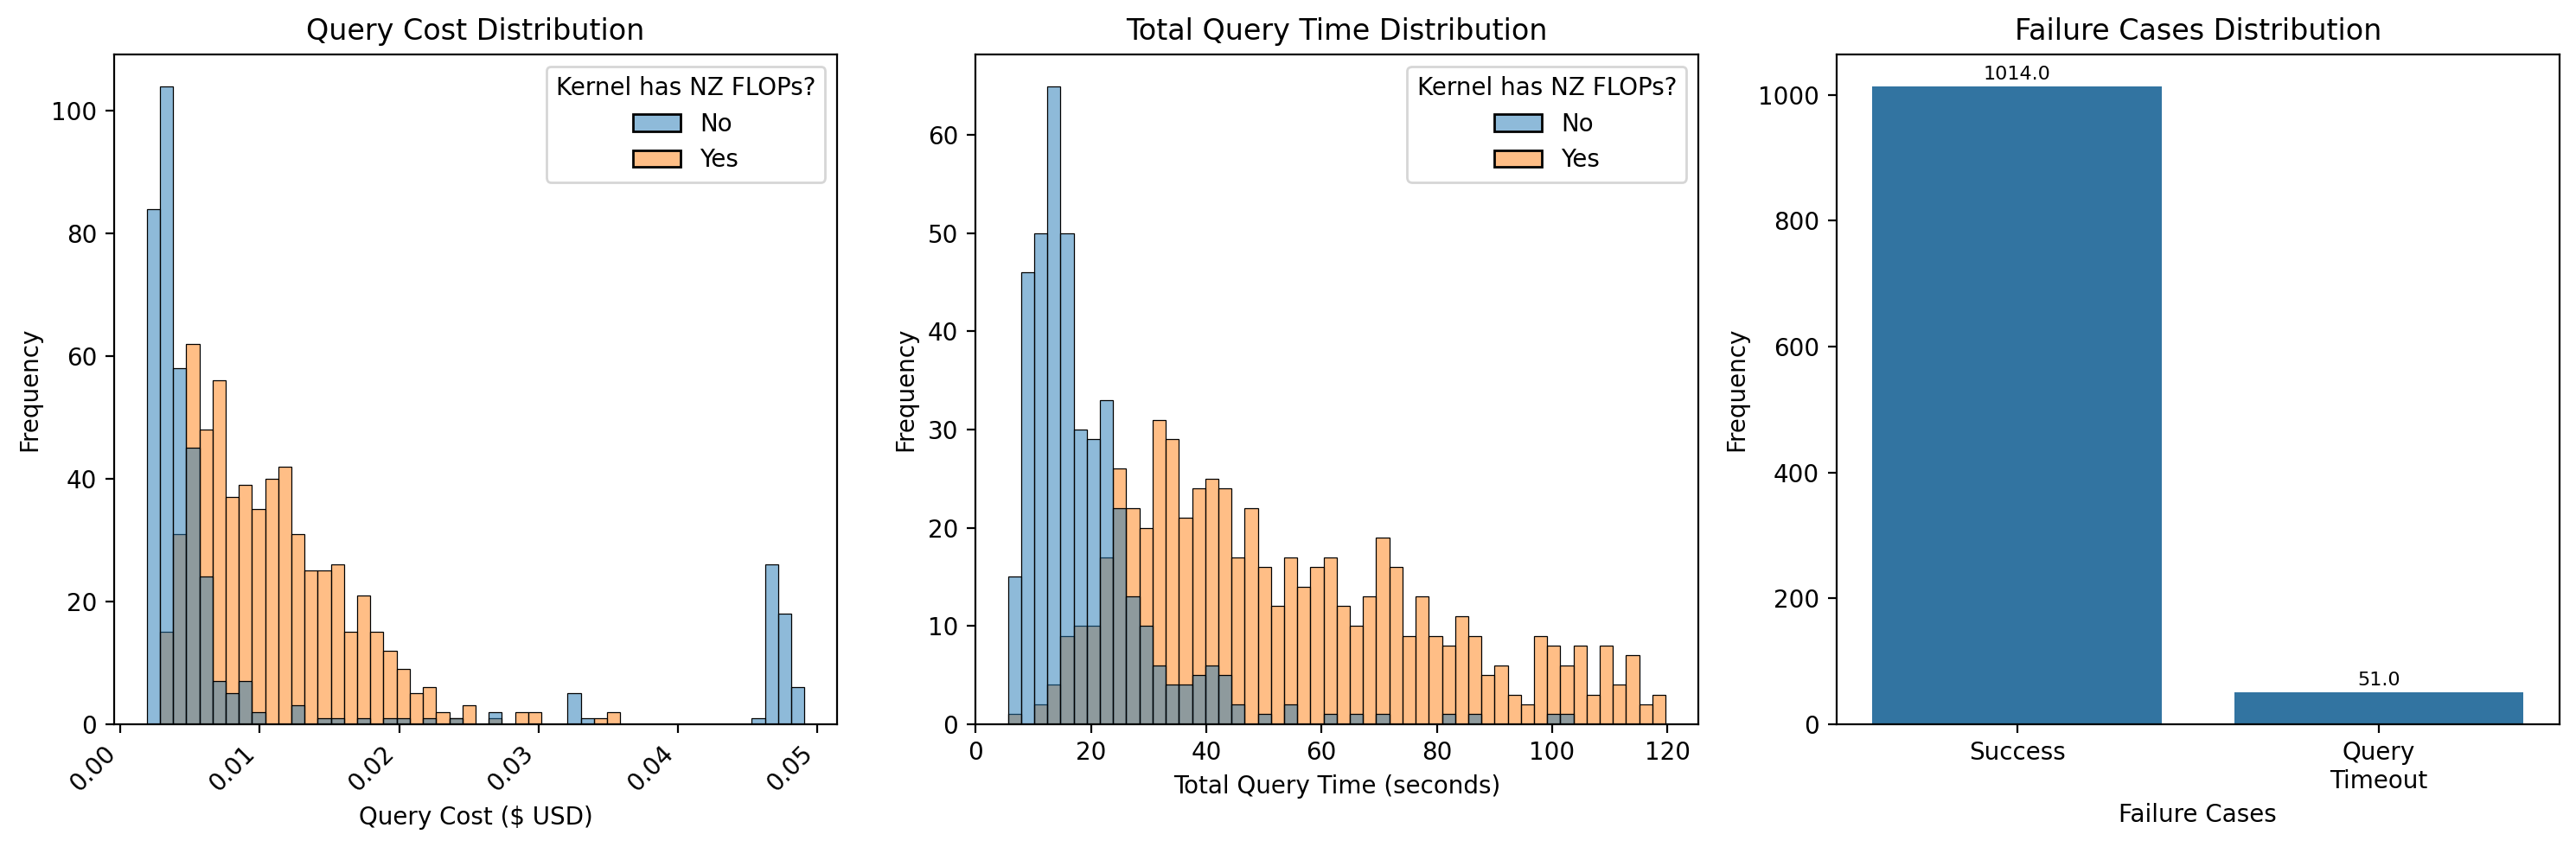

In [90]:
plot_predictions_for_model_name(df, 'gpt-5-mini', 'simple', 'easy')
plot_predictions_for_model_name(df, 'gpt-5-mini', 'full', 'easy')
plot_predictions_for_model_name(df, 'gpt-5-mini', 'simple', 'hard')
plot_predictions_for_model_name(df, 'gpt-5-mini', 'full', 'hard')